**Objective**  
This project focuses on detecting fraudulent transactions from a dataset titled 'creditcard.csv' using five machine learning algorithms which will be assessed based on their performance in training and testing sets — Random Forest, Support Vector Machine, XGBoost, LightGBM, and XGBoost. For each model, baseline performance will be established using the imbalanced dataset followed by investigations of the impact of feature distribution adjustments, and class balancing techniques such as SMOTE. The goal for this study is to identify the most optimal algorithm for detecting rare fraudulent transactions while addressing challenges relating to class imbalance.

**Abstract**  
- The dataset was significantly imbalanced, with fraudulent transactions accounting for only 0.17% of total data. In standard classification algorithms, such data suggests that the model should favour the majority class. As a means of comparison, baseline models were created which were trained and evaluated before any data manipulation, utilising the AUC metric to determine performance. Upon all models, the worst baseline model proved to be **Random Forest** at **97.369%** with SVM as the best at **98.621**. 
- Principal Component Analysis (PCA) was performed first. Whilst dimensionality reduction is very powerful, this dataset had already had dimensionality reduction applied, and due to this, only two features  would have been dropped. As such, I chose to pivot my focus and proceed with data resampling.
- Moving on from PCA, I explored data resampling where I employed **Synthetic Minority Oversampling Technique (SMOTE)** and undersampling to address the extreme class imbalance in the dataset. Employing this led to significant performance improvements in some algorithms validating that severe class imbalance was hindering performance in previous explorations. For algorithms such as **Random Forest** and **CatBoost** resampling demonstrates improvements between **+0.56 - 1.59%**. Despite this, three of the five models showed underperformance, likely due to the synthetic samples introduced and, in turn, class distribution shifts. **CatBoost** displays its adaptability in this scenario with its strong ability to generalise using non-linear, noisy datasets, particularly with synthetic noise.
- Feature enlargement was implemented due to the fact that the dataset was largely numeric, where I expanded the feature space by adding squared terms, increasing the feature count to 58. This benefitted **Random Forest** drastically, whereby its AUC metric increased from **97.369** to **98.967**, and CatBoost, from **98.398%** to **99.935%**. 
- Probability calibration was explored to better reflect the actual likelihood of events, as misclassification is costly. This was performed on the baseline dataset to explore how this dataset could be further improved with additional calibration. Class weights were calculated to a **559:1** (non-fraud to fraud) ratio in order to counteract the imbalanced dataset and increasing the influence of the fraud class (without altering class distribution). Gradient boosting models including **XGBoost**, **LightGBM** and **CatBoost** demonstrated interesting results after calibration efforts. Using Isotonic calibration, **CatBoost's** AUC decreased from **96.879%** to **94.646%**, alongside an increased Brier score (**0.1287** to **0.0846**), suggesting optimal probability estimates, yet a decreased AUC. XGBoost presented similar results, with an AUC of **94.727%** from **95.303%** with isotonic calibration, despite an improvement in Brier score from **0.3145** to **0.0884**. **Random Forest** and **SVM** maintained their AUC scores using Sigmoid calibration, with low Brier scores indicating not much room for improvement. This demonstrates that gradient boosting models benefit exceedingly in comparison to linear, tree-based models.


**Results**  

When comparing the results from each model, the results suggest the most optimal parameters for each algorithm are as follows:
- Random Forest: **98.967%** - Feature Squaring and Removal of Duplicates
- Support Vector Machine: **98.621%** - Baseline Model
- XGBoost: **98.405%** - Feature Squaring and Removal of Duplicates
- LightGBM: **97.687%** - Feature Squaring and Removal of Duplicates
- CatBoost: **99.971%** - SMOTE Resampling

Best Public Test Score : __99.971 - CatBoost__  

| Model|Baseline|Resampling|Enlarged Features|Calibration| Best Test AUC|
|------|-------------------|--------|---------|---------------|---------------|
|Random Forest|97.369%|97.913%|98.967%|95.422%|98.967%|
|Support Vector Machine|**98.621%**|95.775%|92.127%|**96.900%**|98.621%|
|XGBoost|97.482%|96.157%|98.405%|95.303%|98.405%|
|LightGBM|97.672%|95.531%|97.687%|95.257%|97.687%|
|CatBoost|98.398%|**99.971%**|**99.935%**|96.879%|**99.971%**|
|**Best Model**|SVM|CatBoost|CatBoost|SVM|**CatBoost**|

**Table of contents**  

1. [Utilities](#Utilities)  
    1.1. [Libraries](#libraries)  
    1.2. [CSV Importing](#csvimport)  
    1.3. [Data](#Data)  
    1.4. [Functions](#Functions)  
2. [Exploratory Data Analysis](#ExploratoryDataAnalysis)  
    2.1. [General Aspect of Data](#GeneralAspect)  
    2.2. [Feature Correlations](#FeatCorr)  
    2.3. [Baseline Models](#baselines)  
    2.4. [Principal Components Analysis (PCA)](#PCA)  
3. [Feature Engineering](#FeatureEngineering)  
    3.1. [Sampling Methods](#SamplingMethods)  
    3.2. [Enlarging Feature space](#EnlargeFeat)  
    3.3. [Probability Calibration](#ProbCalib)  

### 1 Utilities  <a class="anchor" id="utilities"></a>

### 1.1 Libraries <a class="anchor" id="libraries"></a>
The below defines all of the libraries that will be used during the investigation.

In [93]:
# Paige Haines
# Task 10.2HD
# 20/05/2025
# 220577892

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import pickle
import matplotlib.font_manager as fm
from sklearn.metrics import RocCurveDisplay
import scikitplot as skplt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import RocCurveDisplay
import time

# Evaluation metrics importing
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, recall_score, precision_score, f1_score, auc, brier_score_loss

#Import other ML libraries
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, StackingClassifier

# Import xgboost libraries
import xgboost as xgb
from xgboost import XGBClassifier

# Import lightgbm libraries
import lightgbm as lgb
from lightgbm import LGBMClassifier

# Import catboost libraries
import catboost as cbt
from catboost import CatBoostClassifier

# Import SVM, GridSearch, and other model requirements
from sklearn import svm
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold, cross_val_score
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier, LogisticRegression

# Importing imbalanced data handling
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Importing calibrated classifier and calibration libraries
from sklearn.calibration import CalibratedClassifierCV
from scipy.special import expit

# Remove any warnings
import warnings
import logging
warnings.filterwarnings('ignore')
logging.getLogger("lightgbm").setLevel(logging.CRITICAL)

### 1.2 CSV Importing  <a class="anchor" id="csvimport"></a>
I begin by loading the given .csv file. *Time* and *Amount* columns were dropped from the dataset as these features are not useful information in determining fraud. This was done similarly to Task 10.1D which used the same dataset. To ensure that this has been loaded correctly, I proceed to print the first five rows from the dataset.

In [2]:
# Load data from 10.1D file
data = pd.read_csv('creditcard.csv')

# Amount is standardised into 'normAmount' to normalise transaction values
data['normAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

# Dropping 'Time' and 'Amount' columns
data = data.drop(['Time','Amount'], axis=1)

In [3]:
# Print first five rows of dataset
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


### 1.3 Data  <a class="anchor" id="Data"></a>
**X** features are defined as all columns excluding *Class* while the **y** target variable is *Class*, indicating whether a particular transaction is 'Fraud' [1] or 'Not Fraud' [0]. Data has been split at a ratio of 70/30% with indices reset to align **X** and **y**.

In [4]:
# Set features and target variable
X = data.drop(columns='Class')
y = data['Class']

# Train and test split for dataset (80% training and 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# Reset indices for alignment
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [5]:
# Summary statistics
print("\nSummary statistics:")
print(data.describe())

# Print dataset shape
print(f'Dataset shape: {data.shape}')
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')


Summary statistics:
                 V1            V2            V3            V4            V5  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15  9.604066e-16   
std    1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00  1.380247e+00   
min   -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00 -1.137433e+02   
25%   -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01 -6.915971e-01   
50%    1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02 -5.433583e-02   
75%    1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01  6.119264e-01   
max    2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01  3.480167e+01   

                 V6            V7            V8            V9           V10  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   1.487313e-15 -5.556467e-16  1.213481e-16 -2.406331e-15  2.239053e-15   
std    1.332271e+00  1.237094e

Analysing these above statistics at a glance, I can see that there are 284,807 observations in 30 columns (including the target variable *Class*). I notice that most of these principal components have minimum and maximum values of large magnitudes, which presents the possibility for potential outliers. When analysing component V10, it ranges from **-9.29** to **+4.53** which is very extreme. Other components follow a similar pattern hinting at a potentially imbalanced dataset with lots of noise. This can be further validated by analysing the distribution of 'Fraud' versus 'Not Fraud' in both training and testing datasets.

In [145]:
fraud_percentage = data['Class'].mean() * 100
print(f"Percentage of fraudulent transactions: {fraud_percentage:.2f}%")

Percentage of fraudulent transactions: 0.17%


As above, actual fraudulent transactions account for only **0.17%** of the data within the training and testing sets, heavily suggesting imbalance which will need to be addressed later. 

### 1.4 Functions  <a class="anchor" id="Functions"></a>
Here we define a few functions that we will use later in the project.

In [143]:
def apply_PCA(X, plot=True):
    ''' Fit PCA on data, then plot explained variance if needed 
        Parameter
        ----------
            X : Dataframe that will be scaled and transformed according to PCA 
            plot : Boolean. If True, displays the explained variance by principal components of PCA 
        
        Output
        -------
            Array of principal components resulting from PCA
            Vector of explained variance 
            '''
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA()
    pca_comp = pca.fit_transform(X_scaled)
    explained_var = pca.explained_variance_ratio_
    
    if plot:
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
        ax.plot(range(0, len(explained_var)), explained_var.cumsum(), marker='o')
        ax.set(xlabel = 'Principal components',
               ylabel = 'Inertia')
        plt.axvline(x = 11, color='r', linestyle='--')
        plt.title('Amount of inertia explained by principal components', fontweight='bold')
        plt.show()
    
    return pca_comp, explained_var


def plot_pca_3D(pca_components, labels):
    ''' Plot values of principal components of PCA 
        Parameters
        -----------
            pca_components : Array resulting from fitting PCA to data
            labels : ground truth labels from data '''
    
    not_anomolies = pca_components[labels == 0]
    anomolies = pca_components[labels == 1]

    plot3D = plt.figure().add_subplot(projection='3d')
   
    plot3D.scatter(anomolies[:, 2], anomolies[:, 0], anomolies[:, 1], label='Anomoly', color='r', alpha=1)
    plot3D.scatter(not_anomolies[:, 2], not_anomolies[:, 0], not_anomolies[:, 1],  label='Not Anomoly', color='g', alpha=0.2)    
    plot3D.set_xlabel('First Component')
    plot3D.set_ylabel('Second Component')
    plot3D.set_zlabel('Third Component')
    
    
def plot_learning_auc(cv, model_name, ax):
    ''' Plot mean AUC learning curve based on cross validation result table (Gradient Boosting methods)
        Parameters
        -----------
            cv : Gradient boosting cross validation output DataFrame
            model_name : String for plot title 
            ax : Location of plot in the figure (ex : ax[0])
            
        Ouput
        -----------
            ax : Return axe to fill figure '''
    
    ax.plot(range(cv.shape[0]), cv['train-auc-mean'], label='Train AUC', color='b')
    ax.plot(range(cv.shape[0]), cv['test-auc-mean'], label='Valid AUC', color='g')
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Mean AUC')
    ax.set_title(f'Learning curve - {model_name}', fontweight='bold')
    ax.legend();
    return ax


def plot_roc_curve_manual(y, y_pred, model_name, ax):
    ''' Plot ROC Curve based on model predictions, with focus on AUC metric 
        Parameters
        -----------
            y : Array of ground truth values to predict
            y_pred : Array of predictions (i.e output of model)
            model_name : String for plot title
            ax : Location of plot in the figure (ex. ax[0])
        
        Ouput
        -----------
            ax : Return axe to fill figure '''
    
    fpr, tpr, _ = roc_curve(y, y_pred)
    ax.plot(fpr, tpr, label=f'AUC {model_name} : {roc_auc_score(y, y_pred):.5f}')
    ax.plot([0, 1],[0, 1], ls='--', color='black')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve Validation set', fontweight='bold')
    ax.legend(prop={'size': 11});
    return ax

def calibrate_predictions(classifier, X_train, y_train, X_test, y_test, sample_weight_train, sample_weight_test, cv, method):
    ''' Calibrate predictions with either isotonic or sigmoid method '''
    
    # Ensure consistent float32 dtype across arrays
    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)
    y_train = y_train.astype(np.float32)
    y_test = y_test.astype(np.float32)
    sample_weight_train = sample_weight_train.astype(np.float32)
    sample_weight_test = sample_weight_test.astype(np.float32)
    
    # Fit calibrated classifier
    clf_calib = CalibratedClassifierCV(classifier, cv=cv, method=method)
    clf_calib.fit(X_train, y_train, sample_weight=sample_weight_train)
    
    # Predictions
    preds_calib = clf_calib.predict_proba(X_test)[:, 1]
    
    # Brier Score
    clf_brier_score = brier_score_loss(y_test, preds_calib, sample_weight=sample_weight_test)
    
    return clf_calib, preds_calib, clf_brier_score

def plot_predictions(y_pred, calibration_type, brier_score, ax):
    ax.plot(range(len(y_pred)), np.sort(y_pred), label=f'{calibration_type} ({brier_score:.4f})')
    ax.legend()
    ax.set_title('Model predictions by calibration type (Brier score)', fontweight='bold')
    ax.set_ylabel('$P(Y=1)$')
    ax.set_xlabel('Instances (ordered)')
    return ax

## 2. Exploratory Data Analysis <a class="anchor" id="ExploratoryDataAnalysis"></a>

### 2.1 General Aspects of Data  <a class="anchor" id="GeneralAspect"></a>  

Before going deeper in the data analysis, let's check out some general aspects of the dataset ; 
- are there any missing values (NaN)  
- are there any duplicated values
- is there a difference between the features in the training and test sets  
- differences between features distribution in fraud/not fraud classes

**Missing values**  

None of the datasets contain missing values.

In [7]:
# Checking for missing values
print(f'Missing values in X_train : {X_train.isnull().sum().sum()}')
print(f'Missing values in X_test  : {X_test.isnull().sum().sum()}')

Missing values in X_train : 0
Missing values in X_test  : 0


**Duplicated values**  

Some values are duplicated in the dataset, I will focus on this aspect in the _Feature Engineering_ part.

In [8]:
# Check for duplicated values
print(f'Number of duplicated samples in X_train : {X_train.duplicated().sum()}')
print(f'Number of duplicated samples in X_test  : {X_test.duplicated().sum()}')

Number of duplicated samples in X_train : 5174
Number of duplicated samples in X_test  : 1375


**Features coherence between train and test sets**  

The training and test sets both contain 29 features, and these features are the same between the testing and training sets, ensuring accurate predictions.

In [9]:
# Feature coherence between train and test sets
print(f'Number of features in training set : {len(X_train.columns)}')
print(f'Number of features in test set : {len(X_test.columns)}')
print(f'Features are similar between train and test sets : {all(X_train.columns == X_test.columns)}')

Number of features in training set : 29
Number of features in test set : 29
Features are similar between train and test sets : True


**Class Imbalance**  

When comparing the number of 'Fraud' versus 'Not Fraud' samples, class imbalance becomes very prevalent. In training set, of **199008** samples, only **356** are fraud. In testing set, of **85307**, only **136** are fraud equating to approximately **0.17** of all samples actually being fraud. An imbalanced dataset could allow machine learning models to severely misinterpret the data, leading to poor performance given the overwhelming amount of non-fraud samples. 

In [10]:
# Check distribution in train and test sets
fraud_train = y_train.value_counts()[1]
not_fraud_train = y_train.value_counts()[0]
fraud_test = y_test.value_counts()[1]
not_fraud_test = y_test.value_counts()[0]

# Print fraud percentage in training and testing sets
print(f'\nFraud percentage in train set: {fraud_train}/{not_fraud_train} {round(y_train.mean() * 100, 2)}%')
print(f'Fraud percentage in test set: {fraud_test}/{not_fraud_test} {round(y_test.mean() * 100, 2)}%')


Fraud percentage in train set: 356/199008 0.18%
Fraud percentage in test set: 136/85307 0.16%


**Features distributions by classes**  

Next I examine features distribution by target class. Boxplots are a great way to spot features which have specific distribution if the item is indicative of fraud or not. In these boxplots, it is clear that most of the features display prominent outliers signifying a noisy dataset. As below, it is easy to notice that classes such as **V4**, **V10**, and **V11** show separability between 'Fraudulent Transactions' and 'Authentic Transactions'. Tree-based models like Random Forest and XGBoost are great with identifying these patterns, however others such as SVM may struggle.

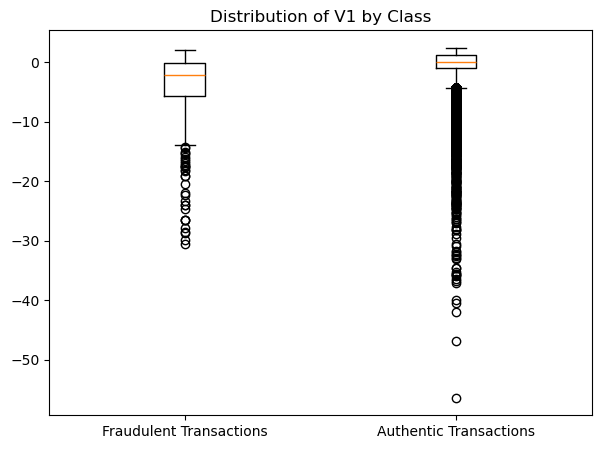

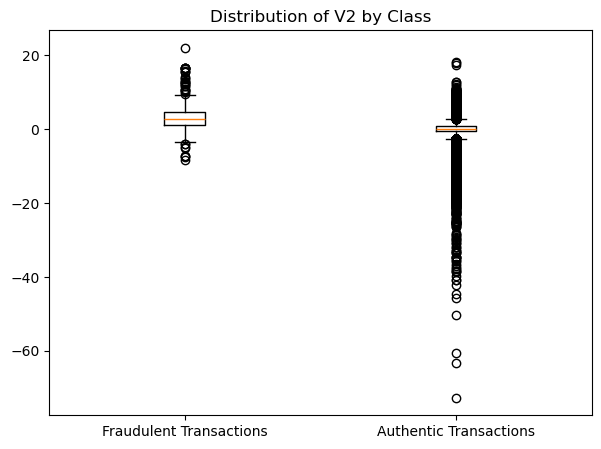

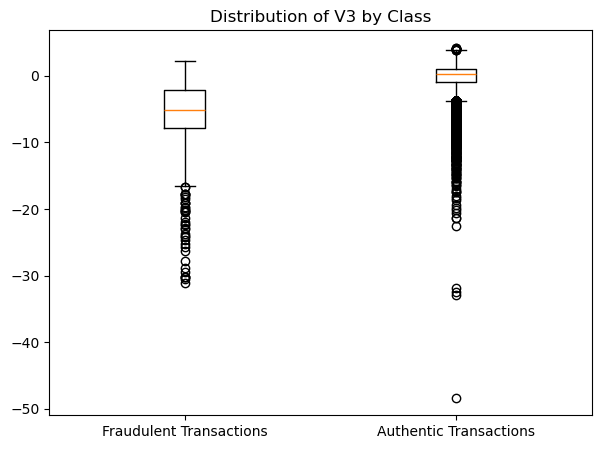

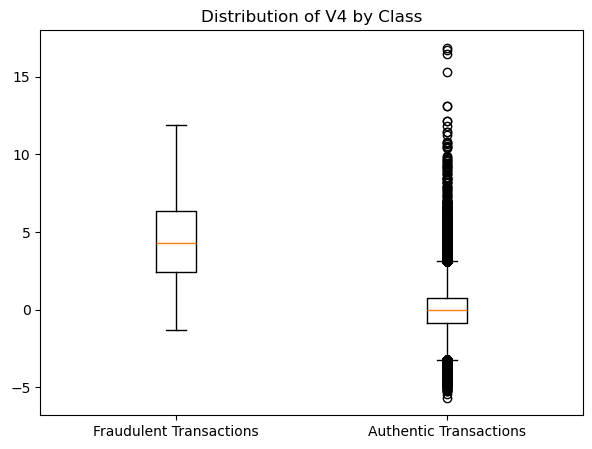

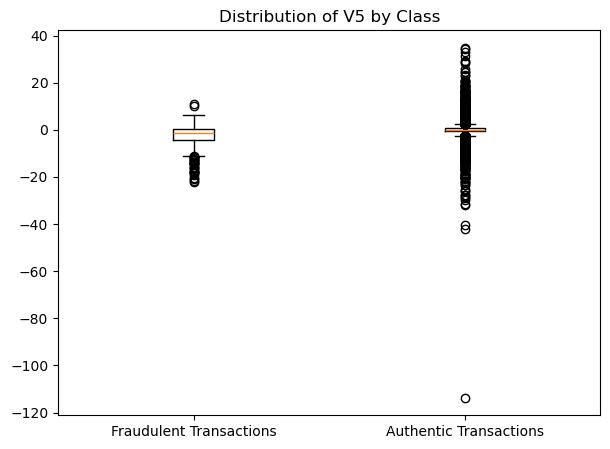

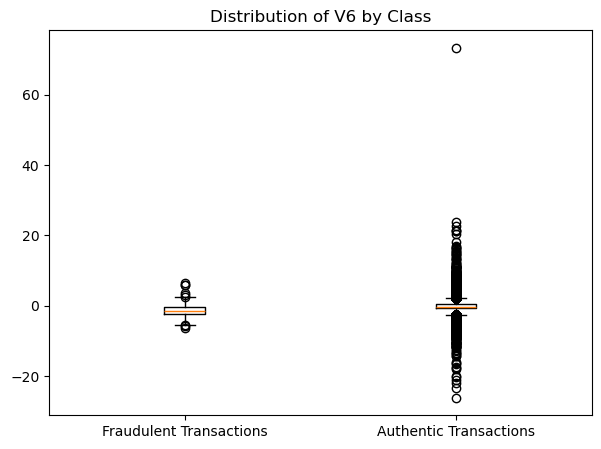

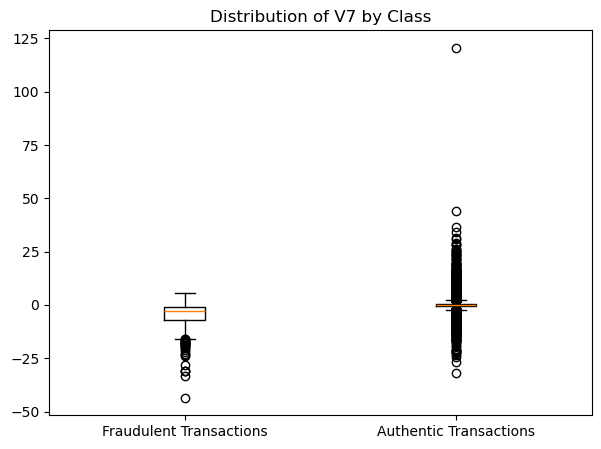

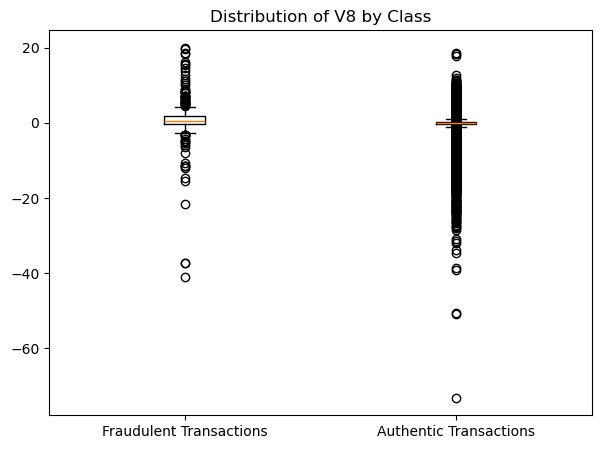

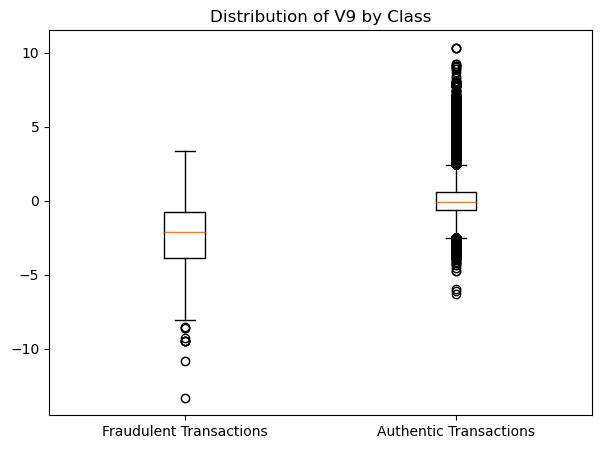

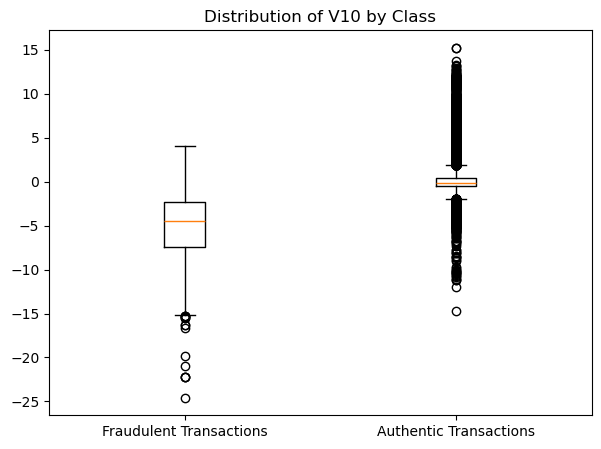

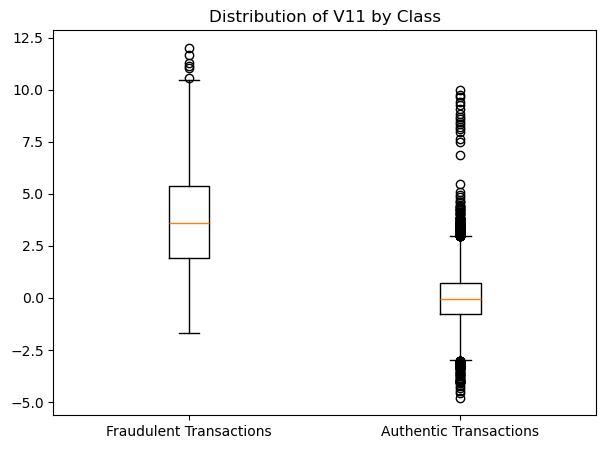

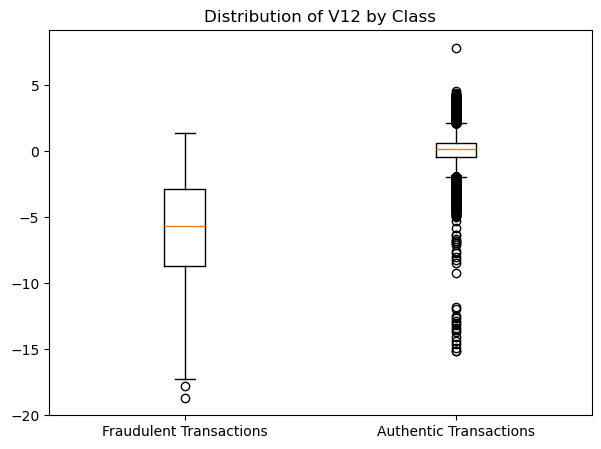

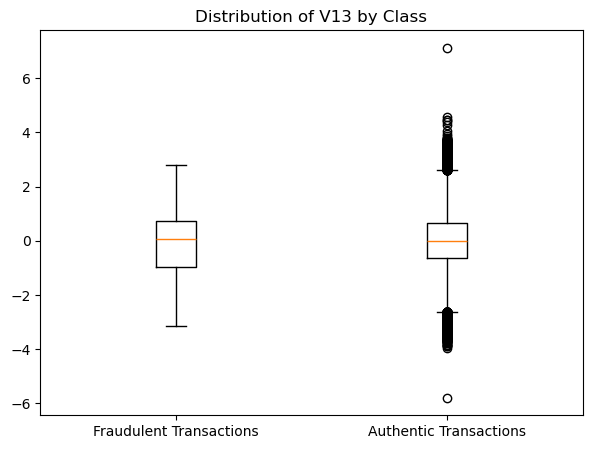

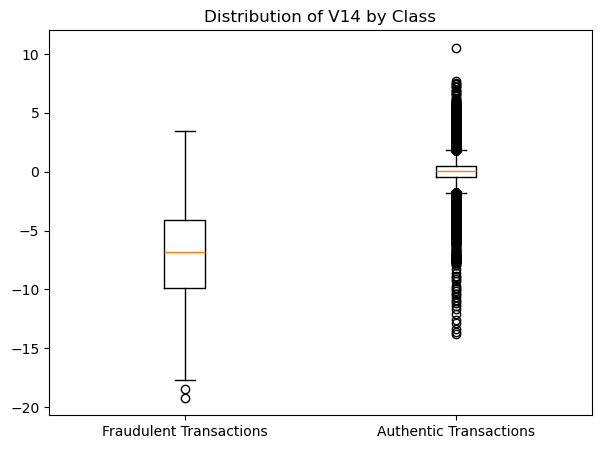

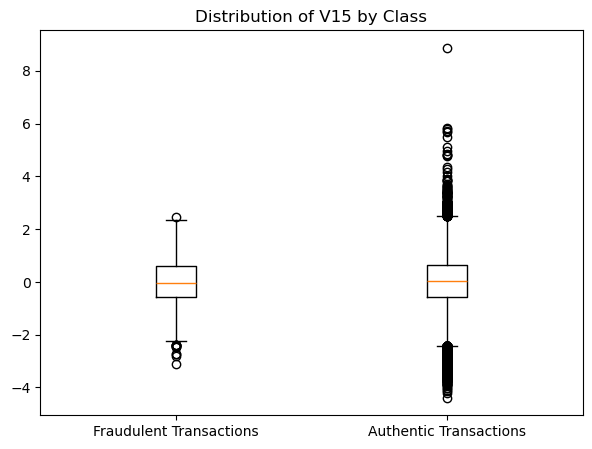

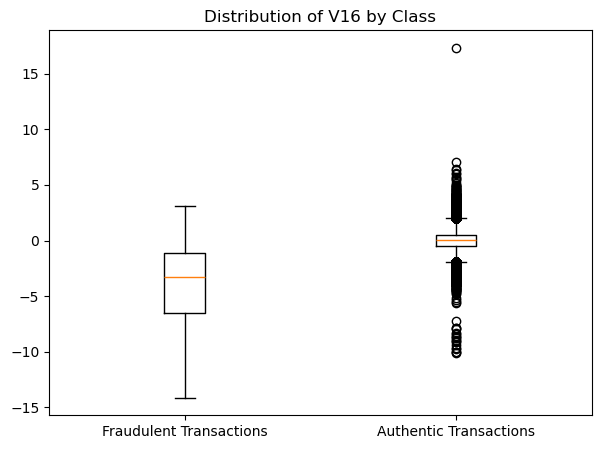

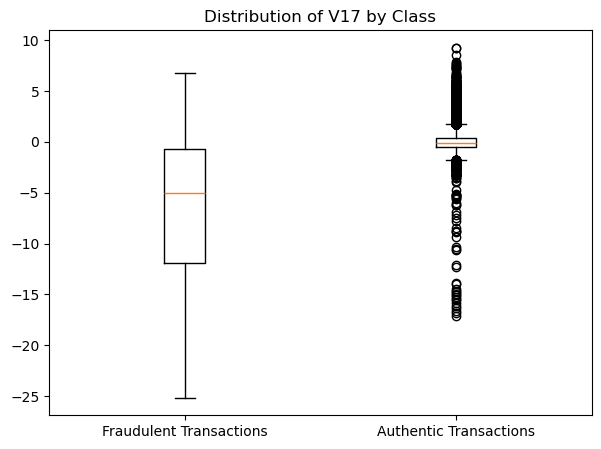

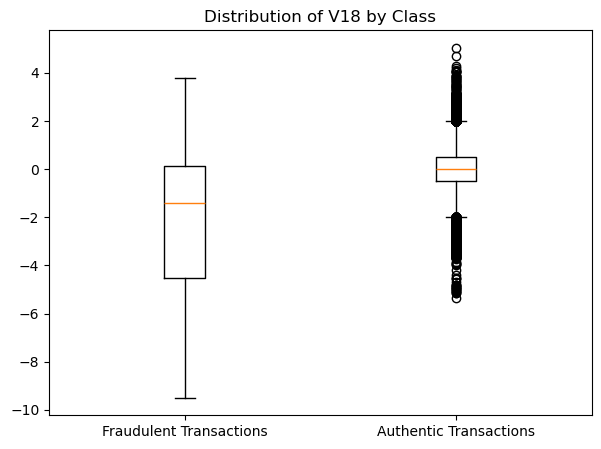

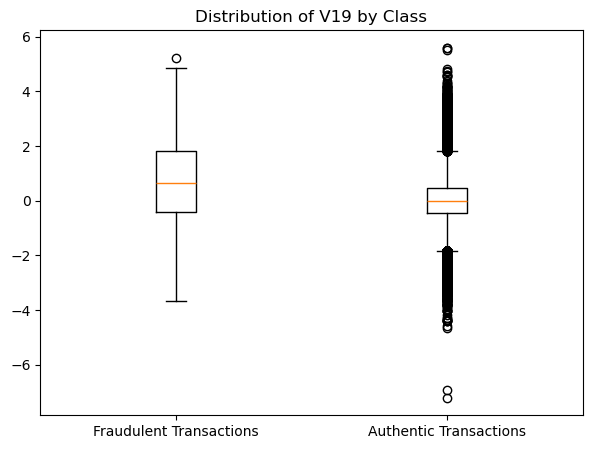

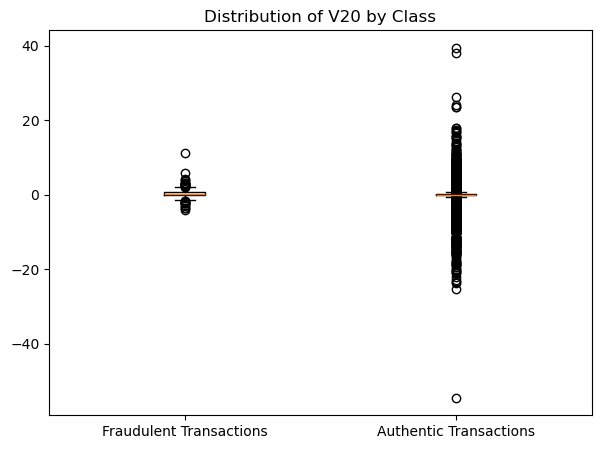

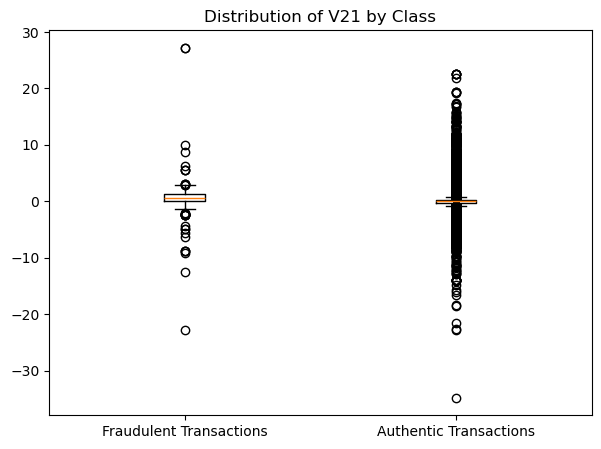

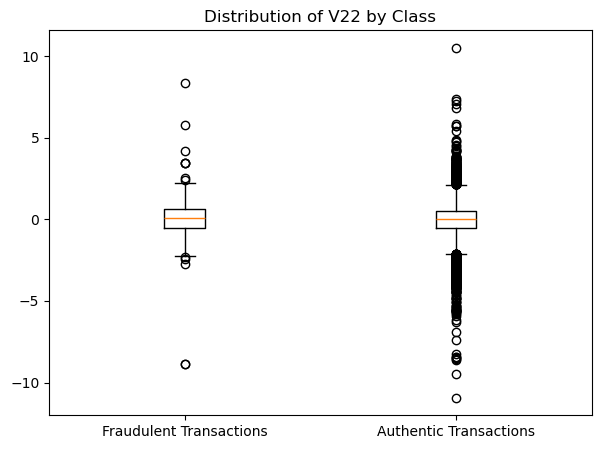

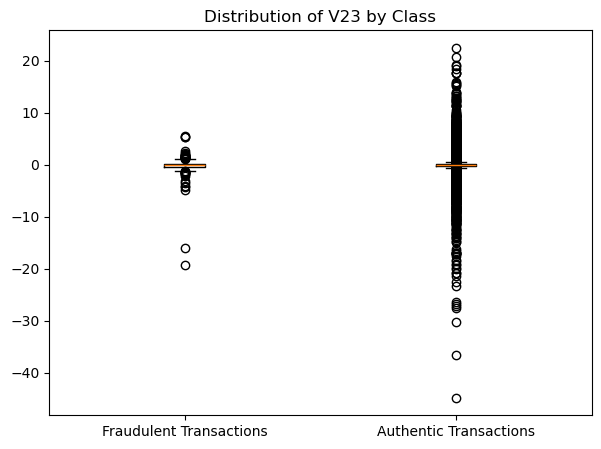

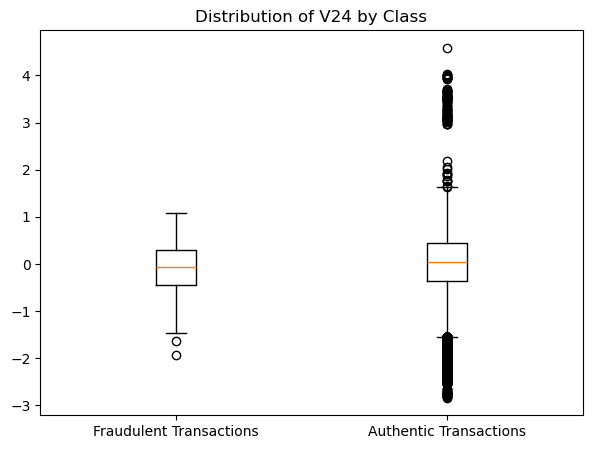

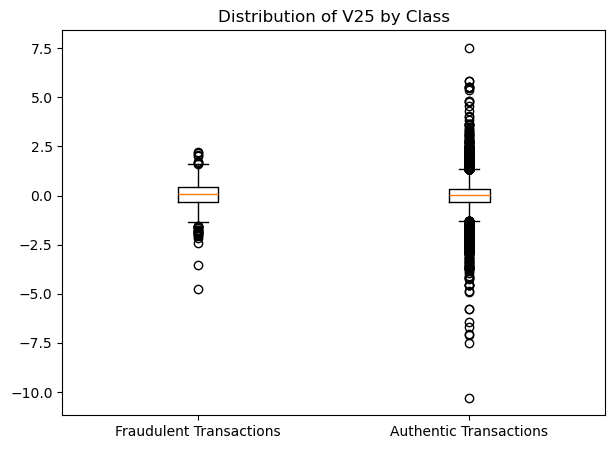

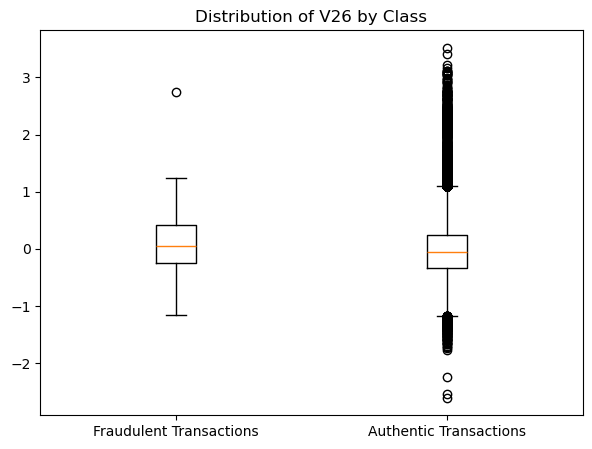

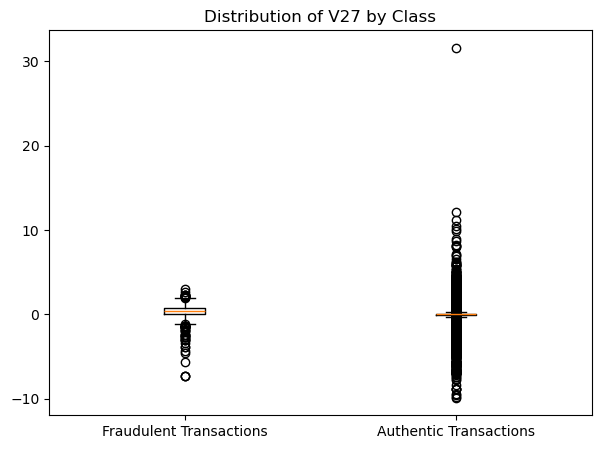

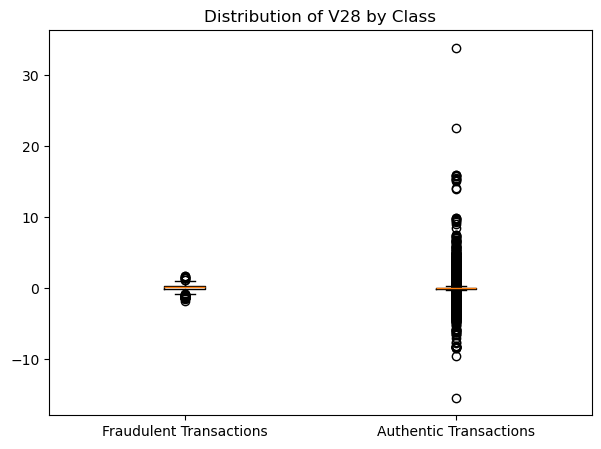

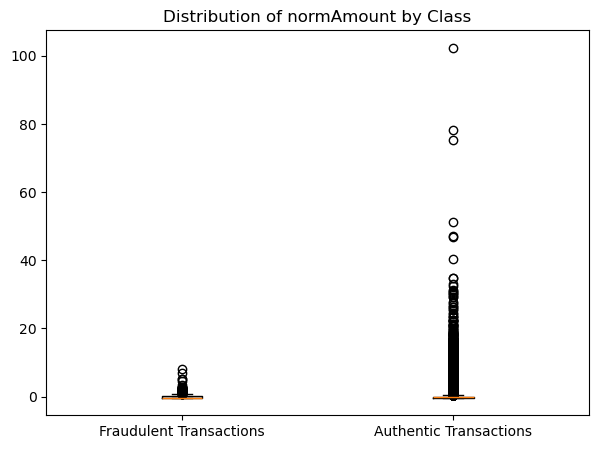

In [11]:
# Features distribution by target class
fraud = X_train[y_train ==1]
not_fraud = X_train[y_train ==0]

# Looop through each class and create a plot
for idx in range(len(X_train.columns)):
    feature = X_train.columns[idx]
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    plt.boxplot([fraud[feature], not_fraud[feature]])    
    plt.title(f'Distribution of {feature} by Class')
    plt.xticks([1, 2], ['Fraudulent Transactions', 'Authentic Transactions']);

### 2.2 Features Correlations  <a class="anchor" id="FeatCorr"></a>  
It can be interesting to get an intuition about the correlations between features, and the correlations between each feature and the target. Analysing the results, it is evident that the most varied relationships are with all other features and normAmount. This is due to the fact that normAmount is a raw, scaled feature, and V-features are PCA-transformed, capturing abstract patterns in the original data.

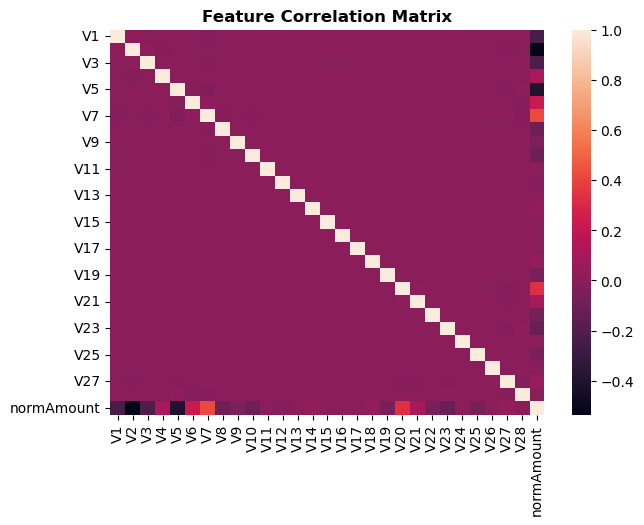

In [12]:
# Correlation matrix of all features in training dataset
corr = X_train.corr()
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
sns.heatmap(corr)
plt.title('Feature Correlation Matrix', fontweight='bold')
plt.show()

**Feature correlation with target**

In this correlation plot, there is a distinct correlation between at least half of the 29 features. **V17** features a correlation coefficient of **0.33** indicating a somewhat moderate level of positive correlation. Overall, most features are **0.20** or below suggesting there is no one feature that is highly predictive. This suggests that important patterns in the data may be non-linear.

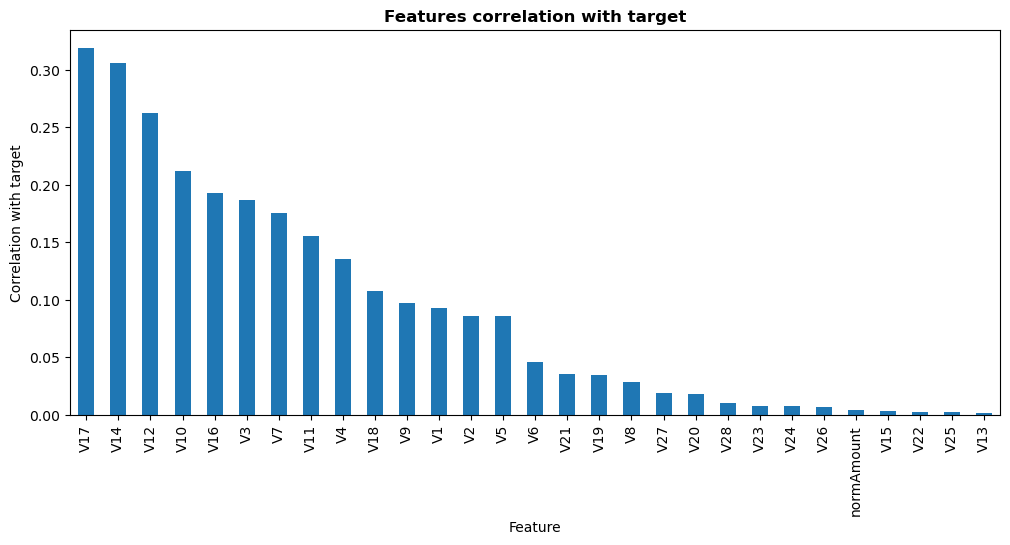

In [13]:
# Feature correlation with target
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
corr_target = np.abs(pd.concat([X_train, y_train], axis=1).corr()['Class']).sort_values(ascending=False)[1:].plot(kind='bar')
plt.title('Features correlation with target', fontweight='bold')
plt.ylabel('Correlation with target')
plt.xlabel('Feature');
plt.show()

In [14]:
# Compute absolute correlations with target
corr_with_target = np.abs(pd.concat([X_train, y_train], axis=1).corr()['Class']).sort_values(ascending=False)

# Drop the correlation of 'Class' with itself
corr_with_target = corr_with_target.drop('Class')

# Print the correlations to the terminal
print("Feature correlations with target:\n")
print(corr_with_target)

Feature correlations with target:

V17           0.318848
V14           0.305740
V12           0.262297
V10           0.212370
V16           0.193176
V3            0.186946
V7            0.175477
V11           0.155631
V4            0.135672
V18           0.107438
V9            0.096935
V1            0.093115
V2            0.085920
V5            0.085749
V6            0.045829
V21           0.035439
V19           0.034937
V8            0.028849
V27           0.019150
V20           0.017815
V28           0.010179
V23           0.008064
V24           0.007380
V26           0.007063
normAmount    0.004111
V15           0.003347
V22           0.002570
V25           0.002380
V13           0.001493
Name: Class, dtype: float64


### 2.3 Baseline Models  <a class="anchor" id="baselines"></a>  
Creating baseline machine learning models was essential in establishing initial performance, which will then be used to determine further improvement. In this investigation, the models that will be utilised include Random Forest, Support Vector Machine, XGBoost, LightGBM, and CatBoost. Each model will be fit to the training data, and then predictions made on the test set. Model performance will be analysed using ROC curves, which display the true positive rate and the AUC score. All baseline parameters are created using GridSearchCV to ensure accuracy to the dataset specificially.

**Random Forest**

Best params: {'class_weight': 'balanced', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2}
Random Forest Train AUC: 0.9954983318382774
Random Forest Test AUC: 0.9736986706835312
CPU times: total: 30 s
Wall time: 11min 45s


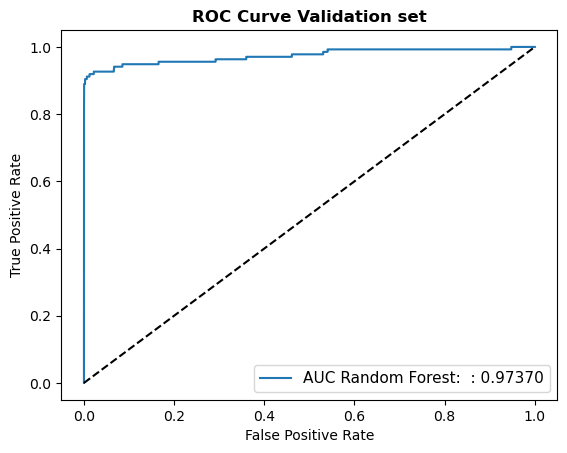

In [15]:
%%time

# Create parameter dictionary
params = {
    'max_depth': [5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 4],
    'max_features': ['log2'],
    'class_weight': ['balanced']
}

# Define base classifier
clf = RandomForestClassifier(n_jobs = -1, n_estimators = 50)

# Cross-validation strategy
cv = RepeatedStratifiedKFold(n_splits = 3)

# Setup GridSearchCV
searchCV = GridSearchCV(
    estimator=clf,
    param_grid=params,
    scoring='roc_auc',
    cv=cv,
    verbose=0,
    n_jobs = -1
)

# Fit with training data
searchCV.fit(X_train, y_train)

# Print best results
print(f'Best params: {searchCV.best_params_}')

# Predict probabilities on training and test sets
rf_train_pred = searchCV.best_estimator_.predict_proba(X_train)[:, 1]
rf_pred = searchCV.best_estimator_.predict_proba(X_test)[:, 1]

# Calculate and print AUC on data
print("Random Forest Train AUC:", roc_auc_score(y_train, rf_train_pred))
print("Random Forest Test AUC:", roc_auc_score(y_test, rf_pred))

# Plot ROC Curve
fig, ax = plt.subplots()
plot_roc_curve_manual(y_test, rf_pred, "Random Forest: ", ax);

**Support Vector Machine**

Best params : {'tol': 0.001, 'penalty': 'l2', 'max_iter': 2000, 'loss': 'hinge', 'fit_intercept': False, 'class_weight': 'balanced', 'alpha': 0.01}
SVM Train AUC: 0.9825955700950874
SVM Test AUC: 0.9684130892361634
CPU times: total: 1.83 s
Wall time: 3min 35s


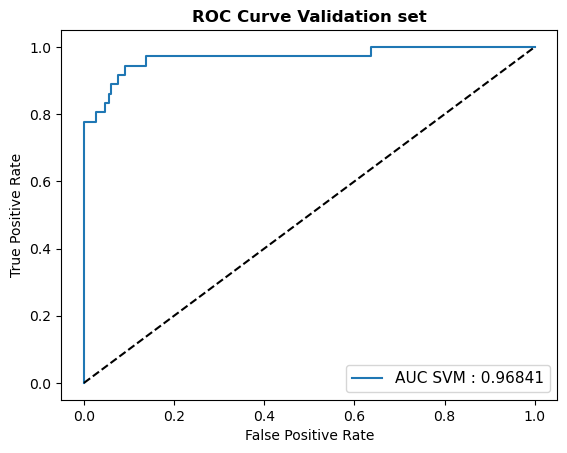

In [43]:
%%time

# Create parameter dictionary
params = {
    'loss': ['hinge', 'squared_hinge'],
    'alpha': [0.001, 0.01],
    'penalty': ['l1', 'l2'],
    'max_iter': [2000],
    'class_weight': ['balanced'],
    'tol': [1e-3, 1e-4],
    'fit_intercept': [False]
}

# Define base classifier
clf = SGDClassifier(n_jobs = -1)

# Cross-validation strategy
cv = RepeatedStratifiedKFold(n_splits = 3)

# Setup GridSearchCV
searchCV = RandomizedSearchCV(
    estimator=clf, 
    param_distributions=params, 
    n_iter=50,
    scoring='roc_auc',
    cv=3,
    verbose=False,
    n_jobs = -1
)

# Fit with training data
searchCV.fit(X_train, y_train)

# Print best results
print(f'Best params : {searchCV.best_params_}')

# Predict probabilities on training and test sets
svm_train_pred = searchCV.best_estimator_.decision_function(X_train) # Decision function to help with ROC curve creation
svm_pred = searchCV.best_estimator_.decision_function(X_test)

# Calculate and print AUC on data
print("SVM Train AUC:", roc_auc_score(y_train, svm_train_pred))
print("SVM Test AUC:", roc_auc_score(y_test, svm_pred))

# Plot ROC curve
fig, ax = plt.subplots()
plot_roc_curve_manual(y_test, svm_pred, "SVM", ax);

**XGBoost**

Best params : {'learning_rate': 0.01, 'max_depth': 5, 'scale_pos_weight': 1, 'subsample': 0.8}
XGBoost Train AUC: 0.9895437056000006
XGBoost Test AUC: 0.9748263451933812
CPU times: total: 10.7 s
Wall time: 5min 46s


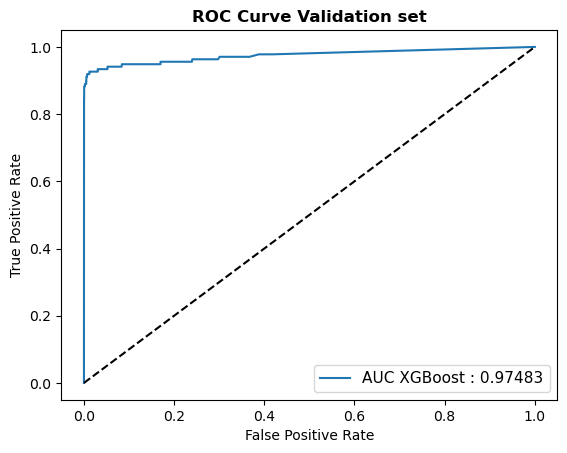

In [17]:
%%time

# Create parameter dictionary
params = {
    'max_depth': [3, 5, 6],
    'learning_rate': [1e-2,12-1],
    'subsample': [0.8, 0.9, 1.0],
    'scale_pos_weight': [1, 5, 10],
}

# Define base classifier
clf = XGBClassifier(n_jobs = -1, booster = 'gbtree', n_estimators = 50)

# Cross-validation strategy
cv = RepeatedStratifiedKFold(n_splits = 3)

# Setup GridSearchCV
searchCV = GridSearchCV(
    estimator=clf, 
    param_grid=params, 
    scoring='roc_auc',
    cv=cv,
    verbose=False,
    n_jobs = -1
)

# Fit with training data
searchCV.fit(X_train, y_train)

# Print best results
print(f'Best params : {searchCV.best_params_}')

# Predict probabilities on training and test sets
xgb_train_pred = searchCV.best_estimator_.predict_proba(X_train)[:, 1]
xgb_pred = searchCV.best_estimator_.predict_proba(X_test)[:, 1]

# Calculate and print AUC on data
print("XGBoost Train AUC:", roc_auc_score(y_train, xgb_train_pred))
print("XGBoost Test AUC:", roc_auc_score(y_test, xgb_pred))

# Plot ROC curve
fig, ax = plt.subplots()
plot_roc_curve_manual(y_test, xgb_pred, "XGBoost", ax);

**LightGBM**

Best params : {'learning_rate': 0.01, 'max_depth': 3, 'num_leaves': 15, 'scale_pos_weight': 5, 'subsample': 0.9}
LightGBM Train AUC: 0.9902882764805571
LightGBM Test AUC: 0.9767215761895273
CPU times: total: 7.59 s
Wall time: 4min


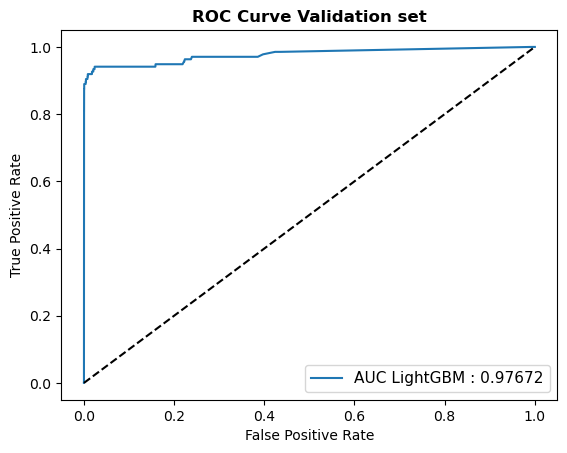

In [18]:
%%time

# Create parameter dictionary
params = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 6],
    'num_leaves': [15, 30],
    'subsample': [0.9, 1.0],
    'scale_pos_weight': [1, 5]
}

# Define base classifier
clf = LGBMClassifier(verbose = -1, n_jobs = -1, n_estimators = 50) # Remove training output for GBM for cleaner notebook

# Cross-validation strategy
cv = RepeatedStratifiedKFold(n_splits=3)

# Setup GridSearchCV
searchCV = GridSearchCV(
    estimator=clf, 
    param_grid=params, 
    scoring='roc_auc',
    cv=cv,
    verbose=False,
    n_jobs = -1
)

# Fit with training data
searchCV.fit(X_train, y_train)

# Print best results
print(f'Best params : {searchCV.best_params_}')

# Predict probabilities on training and test sets
lgb_train_pred = searchCV.best_estimator_.predict_proba(X_train)[:, 1]
lgb_pred = searchCV.best_estimator_.predict_proba(X_test)[:, 1]

# Calculate and print AUC on data
print("LightGBM Train AUC:", roc_auc_score(y_train, lgb_train_pred))
print("LightGBM Test AUC:", roc_auc_score(y_test, lgb_pred))

# Plot ROC curve
fig, ax = plt.subplots()
plot_roc_curve_manual(y_test, lgb_pred, "LightGBM", ax);

**CatBoost**

Best params : {'bootstrap_type': 'Bayesian', 'depth': 8, 'learning_rate': 0.1, 'scale_pos_weight': 1}
CatBoost Train AUC: 0.9938227809372691
CatBoost Test AUC: 0.9839848326356226
CPU times: total: 16.7 s
Wall time: 11min 46s


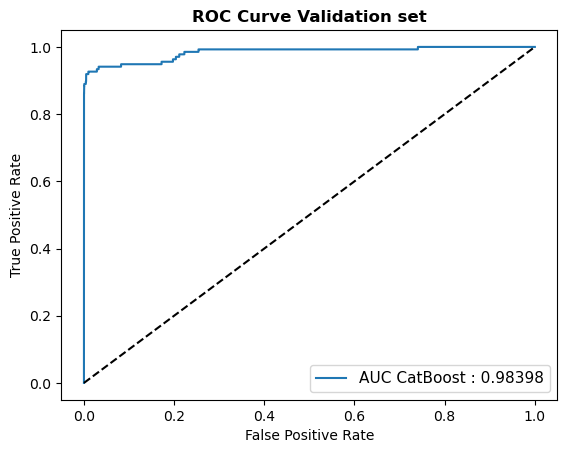

In [19]:
%%time

# Create parameter dictionary:
params = {
    'learning_rate': [0.01, 0.1, 1.0],
    'depth': [4, 6, 8],
    'scale_pos_weight': [1, 5, 7],
    'bootstrap_type': ['Bayesian'],
}

# Define base classifier
clf = CatBoostClassifier(verbose = 0, thread_count = -1, n_estimators = 50) # Remove training output for CatBoost for cleaner notebook

# Cross-validation strategy
cv = RepeatedStratifiedKFold(n_splits = 3)

# Setup GridSearchCV
searchCV = GridSearchCV(
    estimator=clf, 
    param_grid=params, 
    scoring='roc_auc',
    cv=cv,
    verbose=False,
    n_jobs = -1
)

# Fit with training data
searchCV.fit(X_train, y_train)

# Print best results
print(f'Best params : {searchCV.best_params_}')

# Predict probabilities on training and test sets
cat_train_pred = searchCV.best_estimator_.predict_proba(X_train)[:, 1]
cat_pred = searchCV.best_estimator_.predict_proba(X_test)[:, 1]

# Calculate and print AUC on data
print("CatBoost Train AUC:", roc_auc_score(y_train, cat_train_pred))
print("CatBoost Test AUC:", roc_auc_score(y_test, cat_pred))

# Plot ROC curve
fig, ax = plt.subplots()
plot_roc_curve_manual(y_test, cat_pred, "CatBoost", ax);

In [20]:
# Print all AUC results
print("Random Forest Test AUC:", roc_auc_score(y_test, rf_pred))
print("SVM Test AUC:", roc_auc_score(y_test, svm_pred))
print("XGBoost Test AUC:", roc_auc_score(y_test, xgb_pred))
print("LightGBM Test AUC:", roc_auc_score(y_test, lgb_pred))
print("CatBoost Test AUC:", roc_auc_score(y_test, cat_pred))

Random Forest Test AUC: 0.9736986706835312
SVM Test AUC: 0.9862171678898153
XGBoost Test AUC: 0.9748263451933812
LightGBM Test AUC: 0.9767215761895273
CatBoost Test AUC: 0.9839848326356226


**Results**

Comparing the baseline models, SVM boasts the highest AUC score of **98.621%** indicating it is good at handling the features in the dataset, as well as imbalanced data. XGBoost, Random Forest, and LightGBM are also consistently strong, with both results being within the **97's**. CatBoost demonstrates itself as a top contender, with an AUC score of **98.398%**. 

### 2.4 Principal components analysis (PCA)  <a class="anchor" id="PCA"></a>  
Principal Component Analysis (PCA) will be used to reduce the dimensionality of the dataset. As I have noticed, this dataset is high-dimensional, quite noisy, and imbalanced. PCA will allow me to optimise performance while maintaining as much variance as possible, simplifying the feature space in a way that improves overall model performance.

**Variance explained by principal components**  

The explained variance plot displays the proportion of variance captured by each component. The lack of clear **elbow** in the plot indicates that no single component dominates the variance. However, selecting the top 11 principal components allows me to retain approximately **90% of the total variance**. Including more than these 11 components may lead to diminishing returns in model performance due to unnecessary noise or redundant features.

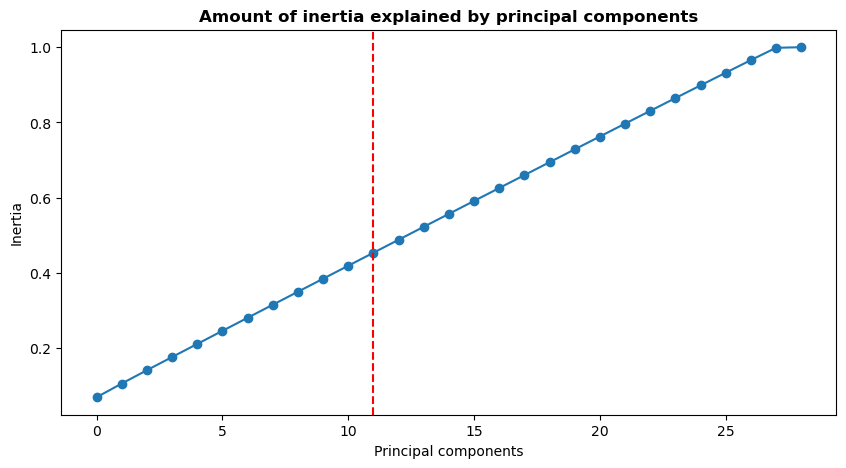

In [21]:
# Fit PCA to X_train data
pca_components, _ = apply_PCA(X_train, plot=True)

**Visualisation** 

Plotting three principal components reveals some clear outliers in the dataset. Some of these points belong to the majority class, indicating that they are not true anomalies but rather a result of potential sensor noise, data entry errors or other kinds of noise. As this dataset is incredibly imbalanced, it is crucial to handle these extreme points appropriately as introducing unnecessary noise degrades model performance. I considered removing a number of these outliers to clean the feature space. As the majority class is overwhelmingly large, this removal is unlikely to compromise any model's learning capacity or skew any class distribution. 

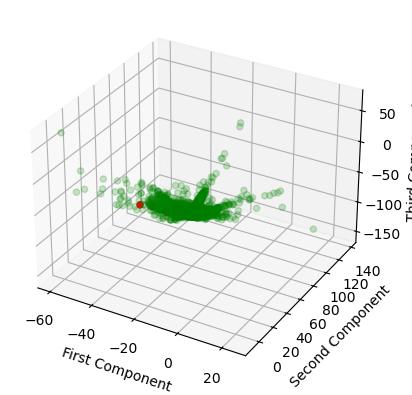

In [22]:
# Plot 3D result of PCA
plot_pca_3D(pca_components, y_train);

**Removing outliers (that are non anomalies)**  

I will proceed to remove outliers in the non-anomaly class and plot data again, in 3D and then 2D. To do so, I employed manual outlier detection and removal in the non-fraud training data, then reapplied PCA, plotting the results. Removing these outliers was undertaken, as in fraud detection extreme values in the feature space may indicate unusual behavior. By addressing these outliers, I am able to create a cleaner version of the dataset, passing a higher quality set to the models. 

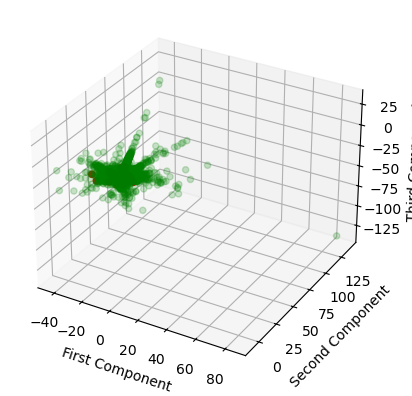

In [23]:
# Outliers in non-anomaly data
indexes_outliers = np.argsort(pca_components[:, 1])[-2:][::-1]

# Removing outliers
X_train_removed = X_train.drop(indexes_outliers)
y_train_removed = y_train.drop(indexes_outliers)

# Fit PCA on cleaned data
pca_components_cleaned, _ = apply_PCA(X_train_removed, plot=False)

# Plot data without outliers
plot_pca_3D(pca_components_cleaned, y_train_removed)

In [24]:
# Apply PCA to the test set to obtain principal components
pca_components_test, _ = apply_PCA(X_test, plot=False)

# Identify the top 2 outliers based on the second principal component
indexes_outliers_test = np.argsort(pca_components_test[:, 1])[-2:][::-1]

# Convert positional indices to actual index labels
index_labels_outliers_test = X_test.iloc[indexes_outliers_test].index

# Remove these outlier samples from both X_test and y_test to clean the test data
X_test_removed = X_test.drop(index_labels_outliers_test)
y_test_removed = y_test.drop(index_labels_outliers_test)

# Re-apply PCA on the cleaned test data for further analysis
X_test_values, _ = apply_PCA(X_test_removed, plot=False)

When removing outliers, I selected the *two* highest values along the second component. Since the removed points were flagged as potential anomalies in the PCA, yet labelled as 'Not Anomoly', I interpreted them as possible artefacts due to sensor noise, or the like.

In [25]:
# Print shapes of original and cleaned training sets
print(f"Original training set size: {X_train.shape[0]}")
print(f"Cleaned training set size: {X_train_removed.shape[0]}")

# Print shapes of original and cleaned testing sets
print(f"Original test set size: {X_test.shape[0]}")
print(f"Cleaned test set size: {X_test_removed.shape[0]}")

Original training set size: 199364
Cleaned training set size: 199362
Original test set size: 85443
Cleaned test set size: 85441


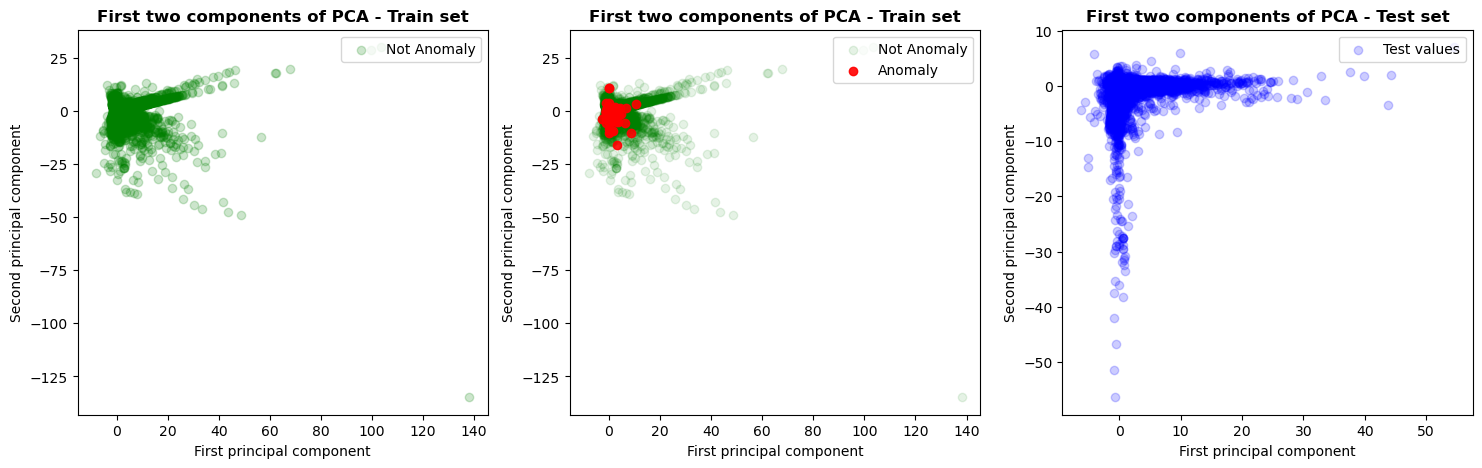

In [26]:
# Separate clean PCA components into fraud, and not fraud samples
anomalies_cleaned = pca_components_cleaned[y_train_removed == 1]
not_anomalies_cleaned = pca_components_cleaned[y_train_removed == 0]

# Plot 2D Result of PCA
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
ax[0].scatter(not_anomalies_cleaned[:, 0], not_anomalies_cleaned[:, 1], label='Not Anomaly', color='g', alpha=0.2)
ax[2].scatter(X_test_values[:, 0], X_test_values[:, 1], label='Test values', color='blue', alpha=0.2)
ax[1].scatter(not_anomalies_cleaned[:, 0], not_anomalies_cleaned[:, 1], label='Not Anomaly', color='g', alpha=0.1)
ax[1].scatter(anomalies_cleaned[:, 0], anomalies_cleaned[:, 1], label='Anomaly', color='r', alpha=0.9)
ax[0].set_title('First two components of PCA - Train set', fontweight='bold')
ax[1].set_title('First two components of PCA - Train set', fontweight='bold')
ax[2].set_title('First two components of PCA - Test set', fontweight='bold')
ax[0].set_xlabel('First principal component')
ax[0].set_ylabel('Second principal component')
ax[0].legend(loc='upper right')
ax[1].set_xlabel('First principal component')
ax[1].set_ylabel('Second principal component')
ax[2].set_xlabel('First principal component')
ax[2].set_ylabel('Second principal component')
ax[1].legend(loc='upper right')
ax[2].legend(loc='upper right');

**Analysing Models Based on PCA Dataset**

Similar to the case study, it is evident that the first two components of the analysis present **significant overlap**. This creates strong noise in model predictions, particularly those that are more linear. Training and test sets show similar data distribution, however, they could benefit from further improvements. Given the reduction of only two features, and the knowledge that this dataset has already had PCA applied beforehand, this reduction would prove incredibly inconsequential. Due to this, I have chosen not to continue with exploring PCA and will instead focus on feature engineering to tune the models further.

## 3. Feature Engineering <a class="anchor" id="FeatureEngineering"></a>

### 3.1 Sampling Methods <a class="anchor" id="SamplingMethods"></a>  
Dealing with highly unbalanced classes can be challenging. **Synthetic Minority Oversampling Technique**, otherwise known as **SMOTE**, can be used to oversample the minority class. As in the case study, I will be using this to oversample and undersample the majority class at a ratio of **0.1** and **0.3**, respectively.

In [27]:
# Define over-sampling and under-sampling strategies
over = SMOTE(sampling_strategy=0.1) # Over sample minority class with SMOTE
under = RandomUnderSampler(sampling_strategy=0.3) # Under sampling majority class

# Create a pipeline to apply over-sampling followed by under-sampling
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# Apply the combined sampling pipeline to training data to balance classes
X_train_smote, y_train_smote = pipeline.fit_resample(X_train, y_train)

# Display new class distribution after resampling
print(f'New distribution of target :\n----------------------------\n{y_train_smote.value_counts()}')

# Split the resampled data into training and unused test subsets (with SMOTE applied)
X_train_smote, X_test_nonused, y_train_smote, y_test_nonused = train_test_split(X_train_smote, y_train_smote, test_size = 0.1, random_state = 0, stratify = y_train_smote.values)

# Split original data into unused training and validation sets (without SMOTE)
X_train_nonused, X_test, y_train_nonused, y_test = train_test_split(X_train, y_train, test_size = 0.1, random_state = 0, stratify = y_train.values)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

New distribution of target :
----------------------------
Class
0    66333
1    19900
Name: count, dtype: int64


**Random Forest**

Random Forest Train AUC: 0.9900469715423014
Random Forest Test AUC: 0.9791307248658637
CPU times: total: 8.73 s
Wall time: 1.4 s


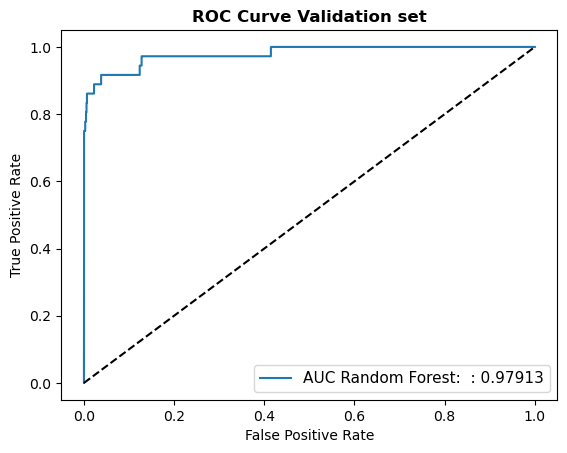

In [120]:
%%time

params = {
    'n_estimators': 50,
    'max_depth': 5,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': 'log2',
    'class_weight': 'balanced'
}

# Define SMOTE classifier
clf = RandomForestClassifier(n_jobs = -1, **params)

# Fit with training data
clf.fit(X_train_scaled, y_train_smote)

# Predict probabilities on train and test sets
rf_train_pred = clf.predict_proba(X_train_scaled)[:, 1]
rf_pred = clf.predict_proba(X_test_scaled)[:, 1]

# Calculate and print AUC on data
print("Random Forest Train AUC:", roc_auc_score(y_train_smote, rf_train_pred))
print("Random Forest Test AUC:", roc_auc_score(y_test, rf_pred))

# Plot ROC Curve
fig, ax = plt.subplots()
plot_roc_curve_manual(y_test, rf_pred, "Random Forest: ", ax);

**Support Vector Machine**

SVM Train AUC: 0.9856174782427263
SVM Test AUC: 0.9577533792271745
CPU times: total: 469 ms
Wall time: 136 ms


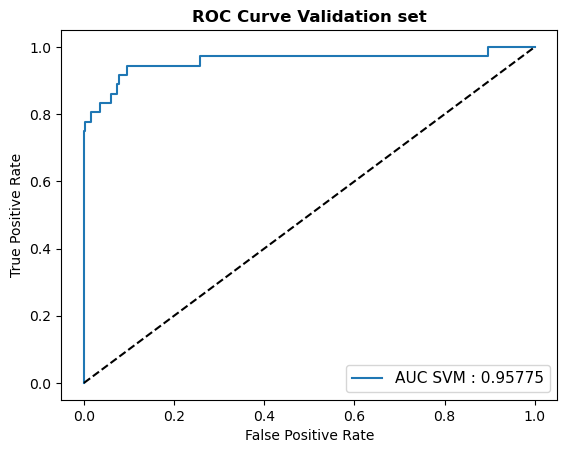

In [121]:
%%time

params = {
    'loss': 'hinge',
    'alpha': 0.01,
    'penalty': 'l2',
    'max_iter': 2000,
    'class_weight': 'balanced',
    'tol': 0.001,
    'fit_intercept': False
}

# Define SMOTE classifier
clf = SGDClassifier(n_jobs = -1, **params)

# Fit with training data
clf.fit(X_train_scaled, y_train_smote)

# Predict probabilities on train and test sets
svm_train_pred = clf.decision_function(X_train_scaled) # Decision function to help with ROC curve creation
svm_pred = clf.decision_function(X_test_scaled)

# Calculate and print AUC on data
print("SVM Train AUC:", roc_auc_score(y_train_smote, svm_train_pred))
print("SVM Test AUC:", roc_auc_score(y_test, svm_pred))

# Plot ROC curve
fig, ax = plt.subplots()
plot_roc_curve_manual(y_test, svm_pred, "SVM", ax);

**XGBoost**

XGBoost Train AUC: 0.9868282400217904
XGBoost Test AUC: 0.9615785638912617
CPU times: total: 1.81 s
Wall time: 269 ms


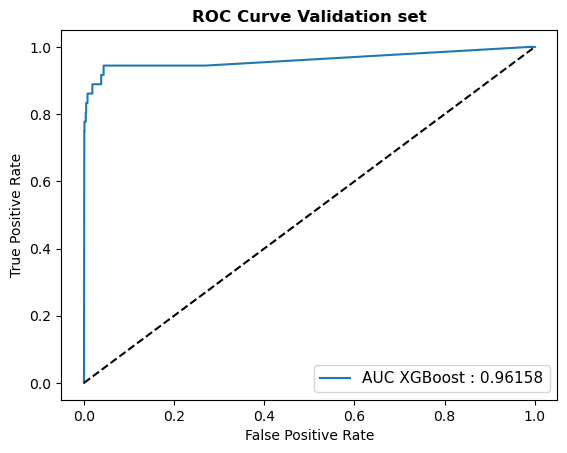

In [122]:
%%time

params = {
    'max_depth': 5,
    'learning_rate': 1e-2,
    'subsample': 0.8,
    'scale_pos_weight': 1,
}

# Define SMOTE classifier
clf = XGBClassifier(n_jobs = -1, n_estimators = 50, **params)

# Fit with training data
clf.fit(X_train_scaled, y_train_smote)

# Predict probabilities on train and test sets
xgb_train_pred = clf.predict_proba(X_train_scaled)[:, 1]
xgb_pred = clf.predict_proba(X_test_scaled)[:, 1]

# Calculate and print AUC on data
print("XGBoost Train AUC:", roc_auc_score(y_train_smote, xgb_train_pred))
print("XGBoost Test AUC:", roc_auc_score(y_test, xgb_pred))

# Plot ROC curve
fig, ax = plt.subplots()
plot_roc_curve_manual(y_test, xgb_pred, "XGBoost", ax);

**LightGBM**

LightGBM Train AUC: 0.9859943245525531
LightGBM Test AUC: 0.9553156178639823
CPU times: total: 1.14 s
Wall time: 196 ms


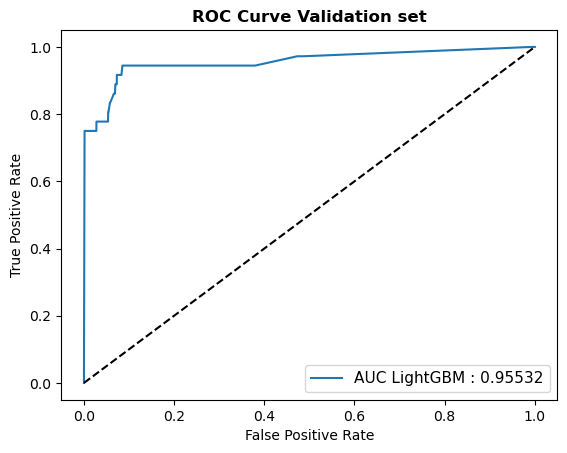

In [123]:
%%time

params = {
    'learning_rate': 0.01,
    'max_depth': 3,
    'num_leaves': 15,
    'subsample': 0.9,
    'scale_pos_weight': 5
}

# Define SMOTE classifier
clf = LGBMClassifier(n_jobs = -1, verbose = -1, n_estimators = 50, **params) # Remove training output for GBM for cleaner notebook

# Fit with training data
clf.fit(X_train_scaled, y_train_smote)

# Predict probabilities on training and test set
lgb_train_pred = clf.predict_proba(X_train_scaled)[:, 1]
lgb_pred = clf.predict_proba(X_test_scaled)[:, 1]

# Calculate and print AUC on data
print("LightGBM Train AUC:", roc_auc_score(y_train_smote, lgb_train_pred))
print("LightGBM Test AUC:", roc_auc_score(y_test, lgb_pred))

# Plot ROC curve
fig, ax = plt.subplots()
plot_roc_curve_manual(y_test, lgb_pred, "LightGBM", ax);

**CatBoost**

CatBoost Train AUC: 0.9998790180506228
CatBoost Test AUC: 0.9997138613916665
CPU times: total: 7.42 s
Wall time: 1.06 s


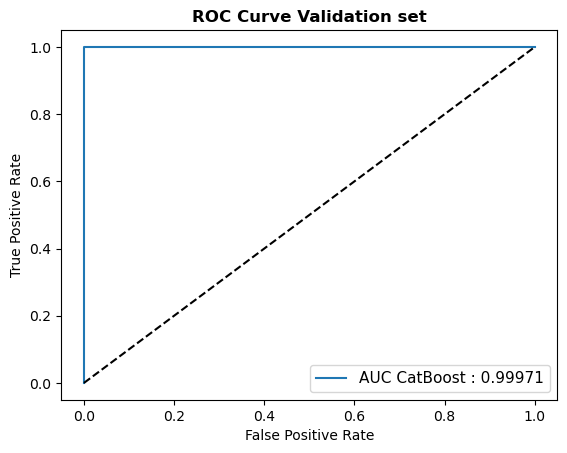

In [124]:
%%time

params = {
    'learning_rate': 0.1,
    'depth': 8,
    'scale_pos_weight': 5,
    'bootstrap_type': 'Bayesian'
}

# Define SMOTE classifier
clf = CatBoostClassifier(verbose = 0, n_estimators = 50, **params)

# Fit with training data
clf.fit(X_train_scaled, y_train_smote)

# Predict probabilities on training and test sets
cat_train_pred = clf.predict_proba(X_train_scaled)[:, 1]
cat_pred = clf.predict_proba(X_test_scaled)[:, 1]

# Calculate and print AUC on data
print("CatBoost Train AUC:", roc_auc_score(y_train_smote, cat_train_pred))
print("CatBoost Test AUC:", roc_auc_score(y_test, cat_pred))

# Plot ROC curve
fig, ax = plt.subplots()
plot_roc_curve_manual(y_test, cat_pred, "CatBoost", ax);

In [125]:
# Print AUC test scores
print("Random Forest Test AUC:", roc_auc_score(y_test, rf_pred))
print("SVM Test AUC:", roc_auc_score(y_test, svm_pred))
print("XGBoost Test AUC:", roc_auc_score(y_test, xgb_pred))
print("LightGBM Test AUC:", roc_auc_score(y_test, lgb_pred))
print("CatBoost Test AUC:", roc_auc_score(y_test, cat_pred))

Random Forest Test AUC: 0.9791307248658637
SVM Test AUC: 0.9577533792271745
XGBoost Test AUC: 0.9615785638912617
LightGBM Test AUC: 0.9553156178639823
CatBoost Test AUC: 0.9997138613916665


**Results**

Employing SMOTE and undersampling demonstrated fascinating results, with only one algorithm notably benefiting from resampling. **Random Forest** and **XGBoost** ever-so-slightly increased from **97.369%** to **97.382%**, and **97.482%** to **97.901%**,  respectively. **SVM** decreased from **98.621%** to **95.837%**, and **LightGBM** from **97.672%** to **95.531%**. **CatBoost** was the only algorithm that benefitted largely from the resampling, adjusting from **98.398%** to **99.971%**, suggesting that it is particularly sensitive to class imbalance and responds well to synthetic samples. Introducing synthetic data to datasets could disadvantage algorithms such as **SVM** and tree-based models due to potential overfitting. In addition, **Random Forest** and **XGBoost** usually benefit from more data, where reducing classes may hinder the models performance. 

### 3.2 Enlarging Feature Space  <a class="anchor" id="EnlargeFeat"></a>    

As the dataset is entirely numeric, no one-hot encoding was necessary. However, I still aim to explore how these engineered features, like squared terms, may adjust the performance even if only marginally. Before proceeding with feature squaring, I will first address the issue of duplicate samples in the dataset introduced in the exploratory step of the investigation.

In [50]:
# Count how many duplicate samples exist in the resampled training set
print(f'Number of duplicated samples in X_train : {X_train.duplicated().sum()}')

# Get class distribution among duplicated samples
counts = y_train[X_train.duplicated(keep=False)].value_counts().values

# Calculate the percentage of anomalies within the duplicated samples
anomaly_ratio = 100 * (counts[1] / (counts[0] + counts[1])) if len(counts) > 1 else 0.0
print(f'Anomaly ratio in duplicated training samples: {anomaly_ratio:.2f}%')

# Print statistics about duplicates before and after resampling, and percentage of duplicates
print(f'Total training samples before resampling: {len(X_train)}')
print(f'Total training samples after resampling: {len(X_train)}')
print(f'Percentage duplicates in training data after resampling: {100 * 1364 / len(X_train):.2f}%')

Number of duplicated samples in X_train : 5174
Anomaly ratio in duplicated training samples: 0.21%
Total training samples before resampling: 199364
Total training samples after resampling: 199364
Percentage duplicates in training data after resampling: 0.68%


Above, I observe that **0.68%** of my original training data contains duplicate samples, with only **0.21%** of those being fraudulent transactions. This implies that duplication mainly affects the majority, legitimate class. Although this level of duplication is relatively low in comparison to the amount of samples in the dataset, I will proceed to remove these duplicates, while performing some feature squaring on the dataset to explore their impact on model performance. 

In [35]:
# Add squared features and duplicate indicator base dataset
column_names = X_train.columns.tolist()
X_train_eng = X_train.copy()
X_test_eng = X_test.copy()

# Create new squared features for each original feature in train and test sets
for col in column_names:
    X_train_eng[f'{col}_sq'] = X_train_eng[col] ** 2
    X_test_eng[f'{col}_sq'] = X_test_eng[col] ** 2

# Remove duplicates but keep original indices
X_train_eng_no_dup = X_train_eng.drop_duplicates(keep='first')
X_test_eng_no_dup = X_test_eng.drop_duplicates(keep='first') 

# Use the same indices to filter y_train_smote
y_train_no_dup = y_train.loc[X_train_eng_no_dup.index]
y_test_no_dup = y_test.loc[X_test_eng_no_dup.index]

# Now reset indices on both for clean consecutive indexing:
X_train_eng_no_dup = X_train_eng_no_dup.reset_index(drop=True)
X_test_eng_no_dup = X_test_eng_no_dup.reset_index(drop=True)
y_train_no_dup = y_train_no_dup.reset_index(drop=True)
y_test_no_dup = y_test_no_dup.reset_index(drop=True)

# Print statistics regarding the removal of duplicates in datasets
print(f'Original X_train samples: {len(X_train_eng)}')
print(f'X_train samples after removing duplicates: {len(X_train_eng_no_dup)}')
print(f'Original X_test samples: {len(X_test_eng)}')
print(f'X_test samples after removing duplicates: {len(X_test_eng_no_dup)}')
print(f'Original y_test samples: {len(y_test)}')
print(f'y_test samples after removing duplicates: {len(y_test_no_dup)}')

Original X_train samples: 199364
X_train samples after removing duplicates: 194190
Original X_test samples: 19937
X_test samples after removing duplicates: 19796
Original y_test samples: 19937
y_test samples after removing duplicates: 19796


Here, I see that the duplicates have been successfully removed. After dropping these duplicates, the training and test samples have no duplicates.

In [36]:
# Reprint duplicate statistics to ensure duplicates have been handled for base dataset
print(f'Number of duplicated samples in X_train : {X_train_eng_no_dup.duplicated().sum()}')

# Calculate the ratio and print the ratio
counts = y_train_no_dup[X_train_eng_no_dup.duplicated(keep=False)].value_counts().values
anomaly_ratio = 100 * (counts[1] / (counts[0] + counts[1])) if len(counts) > 1 else 0.0
print(f'Anomaly ratio in duplicated training samples: {anomaly_ratio:.2f}%')

Number of duplicated samples in X_train : 0
Anomaly ratio in duplicated training samples: 0.00%


**Random Forest**

Random Forest Train AUC: 0.9955388300294301
Random Forest Test AUC: 0.9896730211744634
CPU times: total: 30.5 s
Wall time: 4.62 s


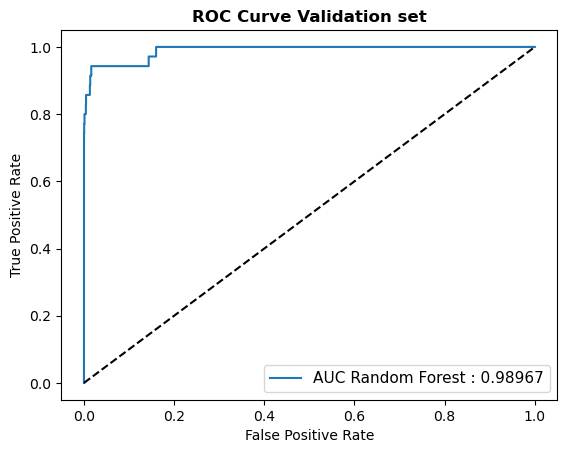

In [48]:
%%time

# Random Forest parameters
params = {
    'n_estimators': 50,
    'max_depth': 5,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': 'log2',
    'class_weight': 'balanced'
}

# Define feature engineering classifier
clf = RandomForestClassifier(n_jobs = -1, **params)

# Fit with training data
clf.fit(X_train_eng_no_dup, y_train_no_dup)

# Predict probabilities on training and test sets
rf_train_pred = clf.predict_proba(X_train_eng_no_dup)[:, 1]
rf_pred = clf.predict_proba(X_test_eng_no_dup)[:, 1]

# Calculate and print AUC on data
print("Random Forest Train AUC:", roc_auc_score(y_train_no_dup, rf_train_pred))
print("Random Forest Test AUC:", roc_auc_score(y_test_no_dup, rf_pred))

# Plot ROC
fig, ax = plt.subplots()
plot_roc_curve_manual(y_test_no_dup, rf_pred, "Random Forest", ax);

**Support Vector Machine**

SVM Train AUC: 0.9748147439382484
SVM Test AUC: 0.9212749499374671
CPU times: total: 1.61 s
Wall time: 1.18 s


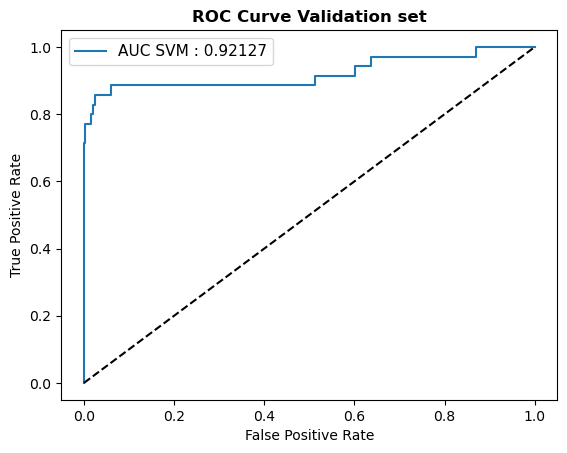

In [47]:
%%time

# SVM parameters
params = {
    'loss': 'hinge',
    'alpha': 0.01,
    'penalty': 'l2',
    'max_iter': 2000,
    'class_weight': 'balanced',
    'tol': 0.001,
    'fit_intercept': False
}

# Define feature engineering classifier
clf = SGDClassifier(n_jobs = -1, **params)

# Fit with training data
clf.fit(X_train_eng_no_dup, y_train_no_dup)

# Predict probabilities on training and test sets
svm_train_pred = clf.decision_function(X_train_eng_no_dup)
svm_pred = clf.decision_function(X_test_eng_no_dup)

# Calculate and print AUC on data
print("SVM Train AUC:", roc_auc_score(y_train_no_dup, svm_train_pred))
print("SVM Test AUC:", roc_auc_score(y_test_no_dup, svm_pred))

# Plot ROC
fig, ax = plt.subplots()
plot_roc_curve_manual(y_test_no_dup, svm_pred, "SVM", ax);

**XGBoost**

XGBoost Train AUC: 0.9908668474253675
XGBoost Test AUC: 0.9840544506856941
CPU times: total: 5.55 s
Wall time: 998 ms


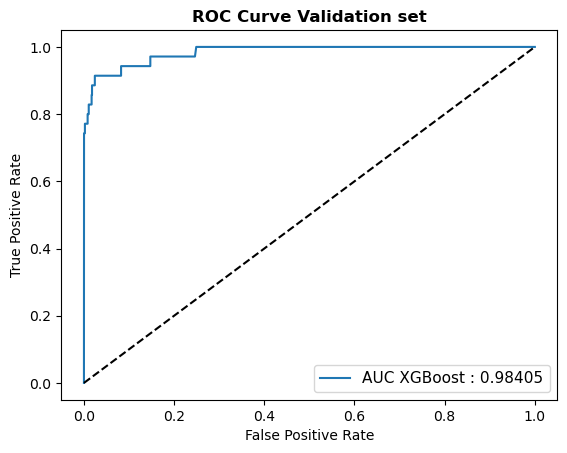

In [46]:
%%time

# XGBoost parameters
params = {
    'max_depth': 5,
    'learning_rate': 1e-2,
    'subsample': 0.8,
    'scale_pos_weight': 1,
}

# Define feature engineering classifier
clf = XGBClassifier(n_jobs = -1, n_estimators = 50, **params)

# Fit with training data
clf.fit(X_train_eng_no_dup, y_train_no_dup)

# Predict probabilities on training and test sets
xgb_train_pred = clf.predict_proba(X_train_eng_no_dup)[:, 1]
xgb_pred = clf.predict_proba(X_test_eng_no_dup)[:, 1]

# Calculate and print AUC on data
print("XGBoost Train AUC:", roc_auc_score(y_train_no_dup, xgb_train_pred))
print("XGBoost Test AUC:", roc_auc_score(y_test_no_dup, xgb_pred))

# Plot ROC
fig, ax = plt.subplots()
plot_roc_curve_manual(y_test_no_dup, xgb_pred, "XGBoost", ax);

**LightGBM**

LightGBM Train AUC: 0.9913959455081158
LightGBM Test AUC: 0.976879423395288
CPU times: total: 4.5 s
Wall time: 796 ms


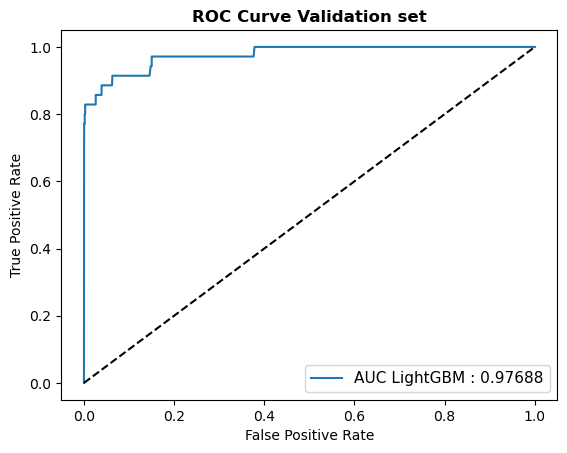

In [40]:
%%time

# LightGBM parameters
params = {
    'learning_rate': 0.01,
    'max_depth': 3,
    'num_leaves': 15,
    'subsample': 0.9,
    'scale_pos_weight': 5
}

# Define feature engineering classifier
clf = LGBMClassifier(n_jobs = -1, verbose = -1, n_estimators = 50, **params)

# Fit with training data
clf.fit(X_train_eng_no_dup, y_train_no_dup)

# Predict probabilities on training and test sets
lgb_train_pred = clf.predict_proba(X_train_eng_no_dup)[:, 1]
lgb_pred = clf.predict_proba(X_test_eng_no_dup)[:, 1]

# Calculate and print AUC on data
print("LightGBM Train AUC:", roc_auc_score(y_train_no_dup, lgb_train_pred))
print("LightGBM Test AUC:", roc_auc_score(y_test_no_dup, lgb_pred))

# Plot ROC
fig, ax = plt.subplots()
plot_roc_curve_manual(y_test_no_dup, lgb_pred, "LightGBM", ax);

**CatBoost**

CatBoost Train AUC: 0.9996262461490828
CatBoost Test AUC: 0.9993551511996935
CPU times: total: 15.7 s
Wall time: 2.35 s


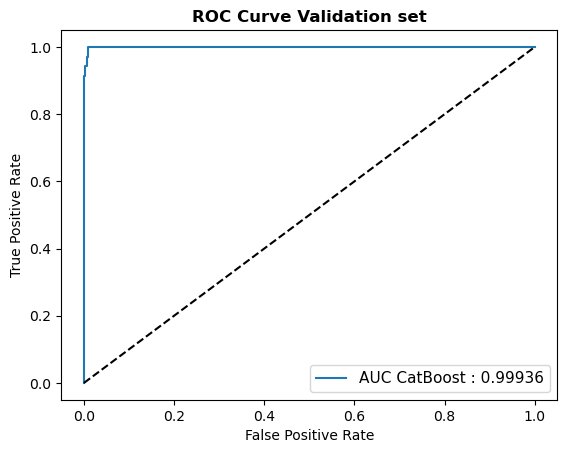

In [41]:
%%time

# CatBoost parameters
params = {
    'learning_rate': 0.1,
    'depth': 8,
    'scale_pos_weight': 5,
    'bootstrap_type': 'Bayesian'
}

# Define feature engineering classifier
clf = CatBoostClassifier(verbose = 0, n_estimators = 50, **params)

# Fit with training data
clf.fit(X_train_eng_no_dup, y_train_no_dup)

# Predict probabilities on training and test sets
cat_train_pred = clf.predict_proba(X_train_eng_no_dup)[:, 1]
cat_pred = clf.predict_proba(X_test_eng_no_dup)[:, 1]

# Calculate and print AUC on data
print("CatBoost Train AUC:", roc_auc_score(y_train_no_dup, cat_train_pred))
print("CatBoost Test AUC:", roc_auc_score(y_test_no_dup, cat_pred))

# Plot ROC
fig, ax = plt.subplots()
plot_roc_curve_manual(y_test_no_dup, cat_pred, "CatBoost", ax);

In [49]:
# Print all AUC results
print("Random Forest Test AUC:", roc_auc_score(y_test_no_dup, rf_pred))
print("SVM Test AUC:", roc_auc_score(y_test_no_dup, svm_pred))
print("XGBoost Test AUC:", roc_auc_score(y_test_no_dup, xgb_pred))
print("LightGBM Test AUC:", roc_auc_score(y_test_no_dup, lgb_pred))
print("CatBoost Test AUC:", roc_auc_score(y_test_no_dup, cat_pred))

Random Forest Test AUC: 0.9896730211744634
SVM Test AUC: 0.9212749499374671
XGBoost Test AUC: 0.9840544506856941
LightGBM Test AUC: 0.976879423395288
CatBoost Test AUC: 0.9993551511996935


In [144]:
print("Number of features in original X_train:", X_train.shape[1])
print("Number of features in squared X_train:", X_train_eng.shape[1])

Number of features in original X_train: 29
Number of features in squared X_train: 58


**Results**

I chose to expand the features to **58**. I also opted to explore another type of feature transformation by adding squared terms of existing features. This approach allowed me to capture non-linear relationships while being resource-conscious. By increasing the dimensionality of the dataset through  feature squaring, non-linear relationships can be observed that may have been missed in the original dataset, enriching the space without changing its inherent nature. For models like **Random Forest**, **XGBoost**, and **LightGBM** this showed marginal but positive improvements at **98.967 (~+1.6%)**, **98.405% (~+0.9%)** and **97.687% (~+0.2%)**, respectively. 

**SVM** was notably the only algorithm that degraded in performance compared to other models, with a total decrease of **~-6.5%** from **98.621%** to **92.127%** suggesting potential overfitting and poorer generalisation due to the introduction of many new squared features, thus increasing the dimensionality of the dataset astronomically. Despite finding the best hyperparameter fit for this dataset, it seems kernel and regularisation adjustments may need to be explored in another iteration of this case study.

**CatBoost** presented the best improvement of all algorithms, with a total improvement of **~1.5%** and whilst quite a small improvement, this allowed the model to be fine-tuned with an AUC score of **99.993%** from **98.398%**. As CatBoost in renowned for its ability to handle non-linear patterns, the enriched feature space (while maintaining its nature) proved quite beneficial. It allowed the algorithms to consider the enhanced decision boundaries which, in turn, led to better detection of fraud.

### 3.3 Probability Calibration  <a class="anchor" id="ProbCalib"></a>    

This next stage assesses the impact of `CalibratedClassifierCV` on model predictions. This will be applied to **Random Forest**, **SVM**, **XGBoost**, **LightGBM**, and **CatBoost** models to analyse performance with calibrated predictions. This section of the investigation is highly influenced by the case study, as this topic is fairly new. 

There are different types of calibration:
* **Isotonic** calibration 
* **Sigmoid** calibration  

**Brier score** will also be implemented to measure calibration where the smaller the score the better. Calibrations will be performed on both the training and test sets.

I am choosing to calibrate the models on the original dataset. Based on the weights of each of the targets, I can begin to perform calibration on these metrics.

In [54]:
# Non anomaly ratio
num = (y_train.value_counts()[0]/len(y_train))
print(num)
denom = (y_train.value_counts()[1]/len(y_train))
print(denom)
res = (num.item(0)/denom.item(0))

# Create sample weights to balance anomaly impact during training
sample_weight = sample_weight = np.array([res if i == 1 else 1 for i in y_train_no_dup.values.ravel()])

# Normalise weights equal to 1
res_array = sample_weight / len(sample_weight)

# Print results
print(res_array)

0.9982143215425051
0.0017856784574948336
[5.14959576e-06 5.14959576e-06 5.14959576e-06 ... 5.14959576e-06
 5.14959576e-06 5.14959576e-06]


The above results show that **~99.82%** of samples are non-fraudulent and **~0.18%** are fraudulent. This class imbalance has been a known challenge identified at the beginning of this case study and such patterns are notoriously difficult for more machine learning algorithms to spot. To mitigate this imbalance, a class weighting ratio of **559** was determined and applied to the fraudulent class to allow these critical classes to contribute more equitably during training. This adjustment allows for better unbiased alignment, and is used to improve recall and AUC for detecting fraud specifically.

**Scaling Data**

Data has been consistently scaled throughout the experiment to ensure that all variables for training and testing are on the same scale, otherwise the models would be unable to make predictions. To explore calibration, I will scale this data into new calibration variables for easy reference using the original dataset as a base to ensure accuracy when simulating real-world fraud detection scenarioss.

In [55]:
# Split the data
X_train_calib, X_test_calib, y_train_calib, y_test_calib, sw_train, sw_test = \
    train_test_split(X_train_eng_no_dup, y_train_no_dup, res_array, test_size=0.1, random_state=42, stratify = y_train_no_dup.values)

In [56]:
# Scale the data
scaler = StandardScaler()
X_train_calib_scaled = scaler.fit_transform(X_train_calib)
X_test_calib_scaled = scaler.transform(X_test_calib)

I analyse the new shapes to confirm that the split has been successful which it has been.

In [57]:
# Print data shapes to confirm scaled datasets
print(X_train_eng_no_dup.shape)
print(y_train_no_dup.shape)
print(X_train_calib.shape)
print(X_test_calib.shape)
print(X_train_calib_scaled.shape)
print(X_test_calib_scaled.shape)

(194190, 58)
(194190,)
(174771, 58)
(19419, 58)
(174771, 58)
(19419, 58)


**Calibration Predictions**  

Calibration is fitted on my predictions, which adjusts the model's outputs based on the true likelihood of the event. I will analyse their results and determine their impact on model performance in comparison to other measures such as SMOTE, and feature engineering efforts.

**Random Forest**

Random Forest Test AUC: 0.9542214492070042
CPU times: total: 27.1 s
Wall time: 4.1 s


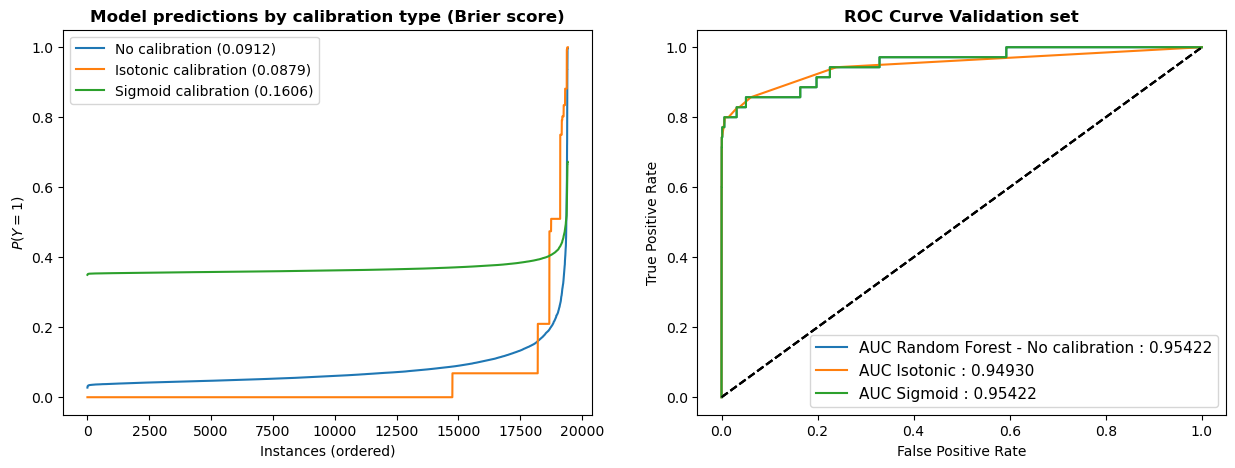

In [128]:
%%time

# Random Forest parameters
params = {
    'n_estimators': 50,
    'max_depth': 5,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': 'log2',
    'class_weight': 'balanced'
}

# Define calibration classifier
rf = RandomForestClassifier(n_jobs = -1, **params)

# Fit with training data
rf.fit(X_train_calib_scaled, y_train_calib)

# No calibration
rf_pred = rf.predict_proba(X_test_calib_scaled)[:, 1]
clf_brier_score = brier_score_loss(y_test_calib, preds_clf, sample_weight=sw_test.ravel())

# Isotonic calibration
clf_calib_iso, preds_calib_iso, brier_score_iso = calibrate_predictions(rf, 
                                                   X_train_calib_scaled, y_train_calib, 
                                                   X_test_calib_scaled, y_test_calib,
                                                   sw_train.ravel(), sw_test.ravel(), 
                                                   'prefit', 'isotonic')

# Sigmoid calibration
clf_calib_sig, preds_calib_sig, brier_score_sig = calibrate_predictions(rf, 
                                                   X_train_calib_scaled, y_train_calib, 
                                                   X_test_calib_scaled, y_test_calib,
                                                   sw_train.ravel(), sw_test.ravel(), 
                                                   'prefit', 'sigmoid')

# Print AUC score
print("Random Forest Test AUC:", roc_auc_score(y_test_calib, rf_pred))

# Calibration plots
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Calibration reliability plots
plot_predictions(preds_clf, 'No calibration', clf_brier_score, ax[0])
plot_predictions(preds_calib_iso, 'Isotonic calibration', brier_score_iso, ax[0])
plot_predictions(preds_calib_sig, 'Sigmoid calibration', brier_score_sig, ax[0])

# ROC curves for calibrated and uncalibrated
plot_roc_curve_manual(y_test_calib, rf_pred, 'Random Forest - No calibration', ax[1])
plot_roc_curve_manual(y_test_calib, preds_calib_iso, 'Isotonic', ax[1])
plot_roc_curve_manual(y_test_calib, preds_calib_sig, 'Sigmoid', ax[1]);

**Support Vector Machine**

SVM Test AUC: 0.9686589823713224
CPU times: total: 1.52 s
Wall time: 644 ms


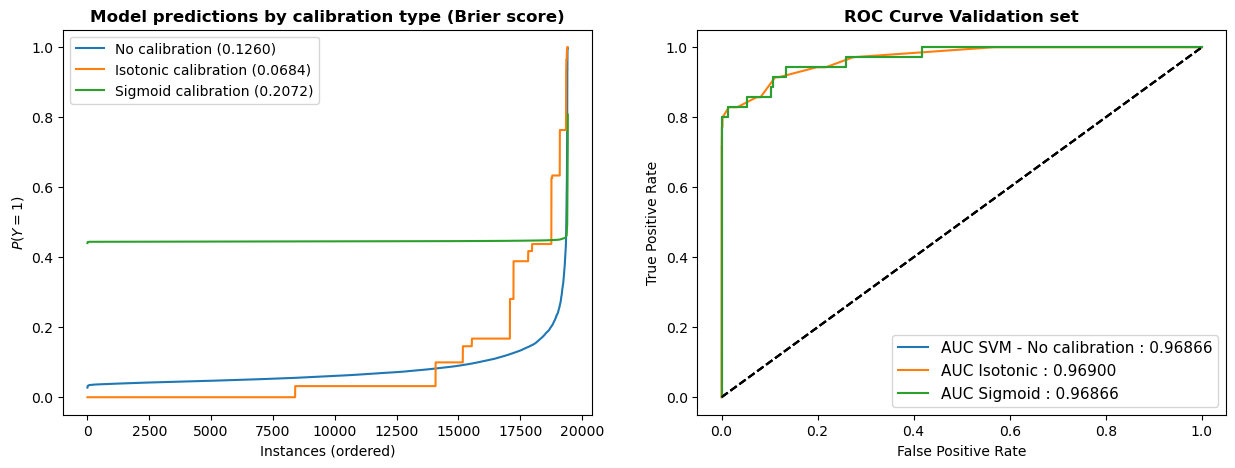

In [137]:
%%time

# SVM parameters
params = {
    'loss': 'hinge',
    'alpha': 0.01,
    'penalty': 'l2',
    'max_iter': 2000,
    'class_weight': 'balanced',
    'tol': 0.001,
    'fit_intercept': False
}

# Define calibration classifier
svm = SGDClassifier(n_jobs = -1, **params)

# Fit with training data
svm.fit(X_train_calib_scaled, y_train_calib)

# No calibration
svm_pred = svm.decision_function(X_test_calib_scaled)
svm_pred_probs = expit(svm_pred)
clf_brier_score = brier_score_loss(y_test_calib, svm_pred_probs, sample_weight=sw_test.ravel())

# Isotonic calibration
clf_calib_iso, preds_calib_iso, brier_score_iso = calibrate_predictions(svm, 
                                                   X_train_calib_scaled, y_train_calib, 
                                                   X_test_calib_scaled, y_test_calib,
                                                   sw_train.ravel(), sw_test.ravel(), 
                                                   'prefit', 'isotonic')

# Sigmoid calibration
clf_calib_sig, preds_calib_sig, brier_score_sig = calibrate_predictions(svm, 
                                                   X_train_calib_scaled, y_train_calib, 
                                                   X_test_calib_scaled, y_test_calib,
                                                   sw_train.ravel(), sw_test.ravel(), 
                                                   'prefit', 'sigmoid')

print("SVM Test AUC:", roc_auc_score(y_test_calib, svm_pred))

# Calibration plots
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Calibration reliability plots
plot_predictions(preds_clf, 'No calibration', clf_brier_score, ax[0])
plot_predictions(preds_calib_iso, 'Isotonic calibration', brier_score_iso, ax[0])
plot_predictions(preds_calib_sig, 'Sigmoid calibration', brier_score_sig, ax[0])

# ROC curves for calibrated and uncalibrated
plot_roc_curve_manual(y_test_calib, svm_pred, 'SVM - No calibration', ax[1])
plot_roc_curve_manual(y_test_calib, preds_calib_iso, 'Isotonic', ax[1])
plot_roc_curve_manual(y_test_calib, preds_calib_sig, 'Sigmoid', ax[1]);

**XGBoost**

XGBoost Test AUC: 0.953031218678144
CPU times: total: 7.52 s
Wall time: 1.04 s


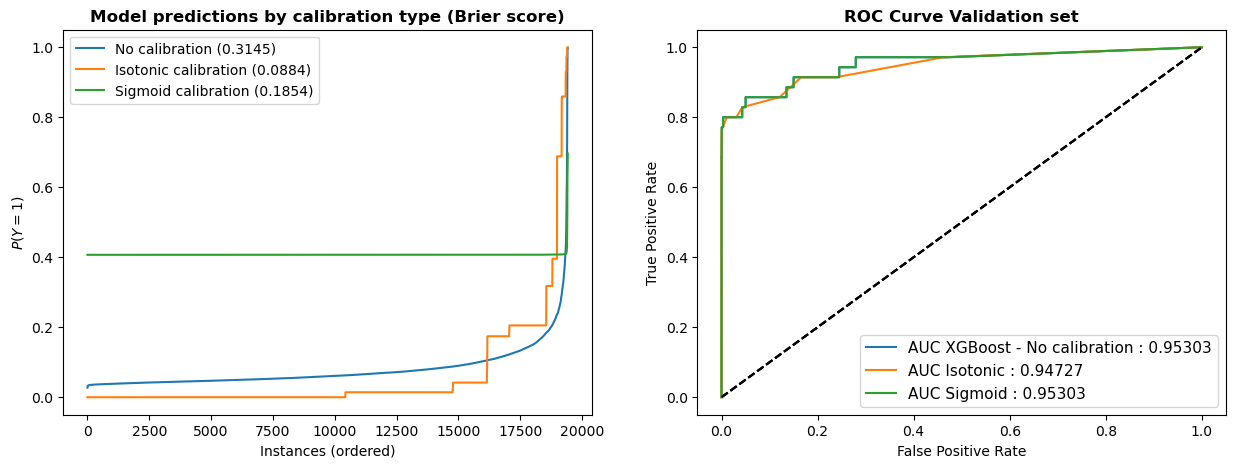

In [131]:
%%time

# XGBoost parameters
params = {
    'max_depth': 5,
    'learning_rate': 1e-2,
    'subsample': 0.8,
    'scale_pos_weight': 1,
}

# Define calibration classifier
xgb = XGBClassifier(n_jobs = -1, n_estimators = 50, **params)

# Fit with training data
xgb.fit(X_train_calib_scaled, y_train_calib)

# No calibration
xgb_pred = xgb.predict_proba(X_test_calib_scaled)[:, 1]
clf_brier_score = brier_score_loss(y_test_calib, xgb_pred, sample_weight=sw_test.ravel())

# Isotonic calibration
clf_calib_iso, preds_calib_iso, brier_score_iso = calibrate_predictions(
    xgb, 
    X_train_calib_scaled.astype(np.float32), 
    y_train_calib.astype(np.float32),
    X_test_calib_scaled.astype(np.float32), 
    y_test_calib.astype(np.float32),
    sw_train.ravel().astype(np.float32), 
    sw_test.ravel().astype(np.float32),
    'prefit', 
    'isotonic'
)

# Sigmoid calibration
clf_calib_sig, preds_calib_sig, brier_score_sig = calibrate_predictions(
    xgb, 
    X_train_calib_scaled.astype(np.float32), 
    y_train_calib.astype(np.float32),
    X_test_calib_scaled.astype(np.float32), 
    y_test_calib.astype(np.float32),
    sw_train.ravel().astype(np.float32), 
    sw_test.ravel().astype(np.float32),
    'prefit', 
    'sigmoid'
)

print("XGBoost Test AUC:", roc_auc_score(y_test_calib, xgb_pred))

# Calibration plots
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Calibration reliability plots
plot_predictions(preds_clf, 'No calibration', clf_brier_score, ax[0])
plot_predictions(preds_calib_iso, 'Isotonic calibration', brier_score_iso, ax[0])
plot_predictions(preds_calib_sig, 'Sigmoid calibration', brier_score_sig, ax[0])

# ROC curves for calibrated and uncalibrated
plot_roc_curve_manual(y_test_calib, xgb_pred, 'XGBoost - No calibration', ax[1])
plot_roc_curve_manual(y_test_calib, preds_calib_iso, 'Isotonic', ax[1])
plot_roc_curve_manual(y_test_calib, preds_calib_sig, 'Sigmoid', ax[1]);

**LightGBM**

LightGBM Test AUC: 0.9525735510877897
CPU times: total: 5.28 s
Wall time: 1.02 s


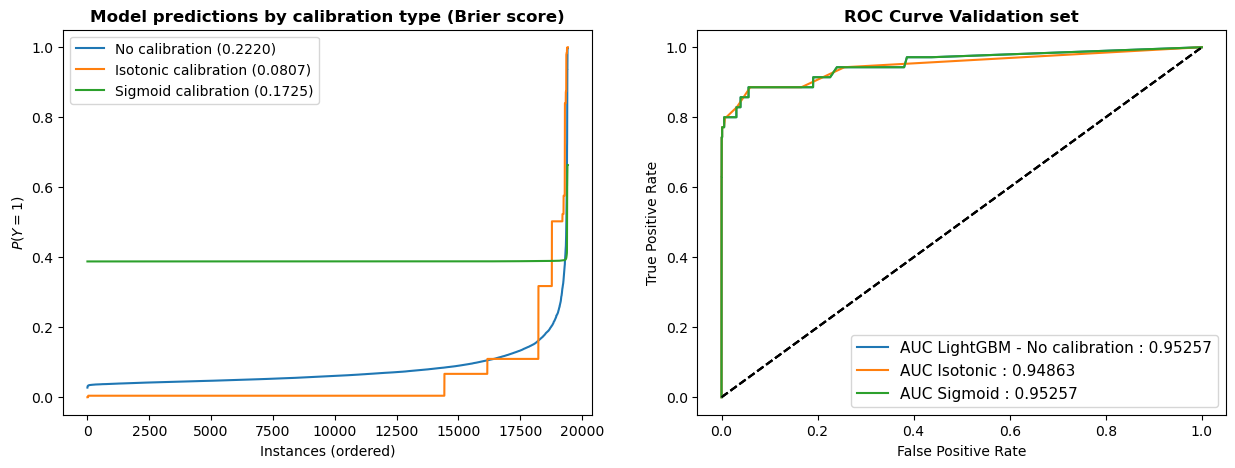

In [133]:
%%time

# LightGM parameters
params = {
    'learning_rate': 0.01,
    'max_depth': 3,
    'num_leaves': 15,
    'subsample': 0.9,
    'scale_pos_weight': 5
}

# Define calibration classifier
lgb = LGBMClassifier(n_jobs = -1, verbose = -1, n_estimators = 50, **params)

# Fit with training data
lgb.fit(X_train_calib_scaled, y_train_calib)

# No calibration
lgb_pred = lgb.predict_proba(X_test_calib_scaled)[:, 1]
clf_brier_score = brier_score_loss(y_test_calib, lgb_pred, sample_weight=sw_test.ravel())

# Isotonic calibration
clf_calib_iso, preds_calib_iso, brier_score_iso = calibrate_predictions(lgb, 
                                                   X_train_calib_scaled, y_train_calib, 
                                                   X_test_calib_scaled, y_test_calib,
                                                   sw_train.ravel(), sw_test.ravel(), 
                                                   'prefit', 'isotonic')

# Sigmoid calibration
clf_calib_sig, preds_calib_sig, brier_score_sig = calibrate_predictions(lgb, 
                                                   X_train_calib_scaled, y_train_calib, 
                                                   X_test_calib_scaled, y_test_calib,
                                                   sw_train.ravel(), sw_test.ravel(), 
                                                   'prefit', 'sigmoid')

print("LightGBM Test AUC:", roc_auc_score(y_test_calib, lgb_pred))

# Calibration plots
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Calibration reliability plots
plot_predictions(preds_clf, 'No calibration', clf_brier_score, ax[0])
plot_predictions(preds_calib_iso, 'Isotonic calibration', brier_score_iso, ax[0])
plot_predictions(preds_calib_sig, 'Sigmoid calibration', brier_score_sig, ax[0])

# ROC curves for calibrated and uncalibrated
plot_roc_curve_manual(y_test_calib, lgb_pred, 'LightGBM - No calibration', ax[1])
plot_roc_curve_manual(y_test_calib, preds_calib_iso, 'Isotonic', ax[1])
plot_roc_curve_manual(y_test_calib, preds_calib_sig, 'Sigmoid', ax[1]);

**CatBoost**

CatBoost Test AUC: 0.9687872177348034
CPU times: total: 16.2 s
Wall time: 2.5 s


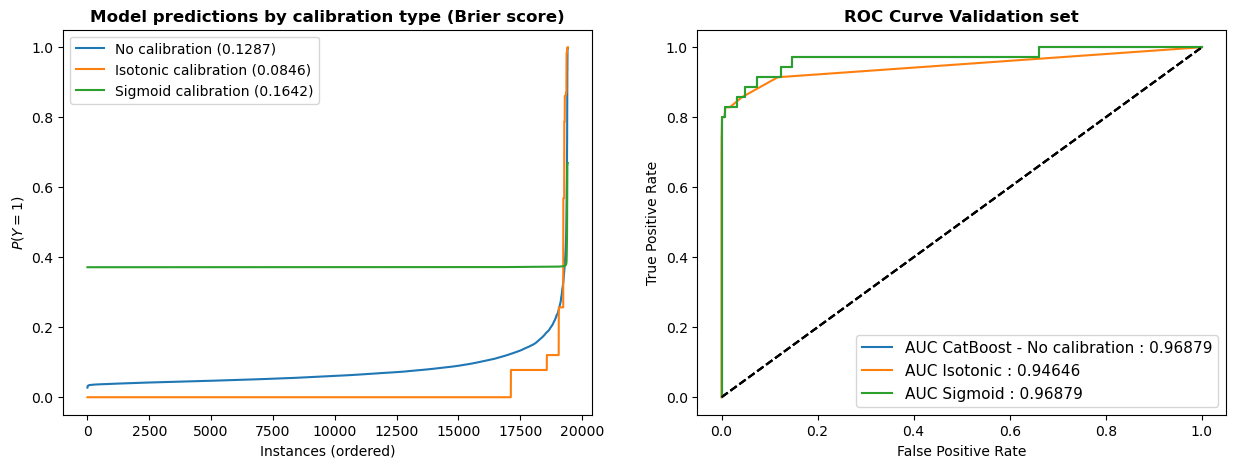

In [134]:
%%time

# CatBoost parameters
params = {
    'learning_rate': 0.1,
    'depth': 8,
    'scale_pos_weight': 5,
    'bootstrap_type': 'Bayesian'
}

# Define calibration classifier
cat = CatBoostClassifier(verbose = 0, n_estimators = 50, **params)

# Fit with training data
cat.fit(X_train_calib_scaled, y_train_calib)

# No calibration
cat_pred = cat.predict_proba(X_test_calib_scaled)[:, 1]
clf_brier_score = brier_score_loss(y_test_calib, cat_pred, sample_weight=sw_test.ravel())

# Isotonic calibration
clf_calib_iso, preds_calib_iso, brier_score_iso = calibrate_predictions(cat, 
                                                   X_train_calib_scaled, y_train_calib, 
                                                   X_test_calib_scaled, y_test_calib,
                                                   sw_train.ravel(), sw_test.ravel(), 
                                                   'prefit', 'isotonic')

# Sigmoid calibration
clf_calib_sig, preds_calib_sig, brier_score_sig = calibrate_predictions(cat, 
                                                   X_train_calib_scaled, y_train_calib, 
                                                   X_test_calib_scaled, y_test_calib,
                                                   sw_train.ravel(), sw_test.ravel(), 
                                                   'prefit', 'sigmoid')


print("CatBoost Test AUC:", roc_auc_score(y_test_calib, cat_pred))

# Calibration plots
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Calibration reliability plots
plot_predictions(preds_clf, 'No calibration', clf_brier_score, ax[0])
plot_predictions(preds_calib_iso, 'Isotonic calibration', brier_score_iso, ax[0])
plot_predictions(preds_calib_sig, 'Sigmoid calibration', brier_score_sig, ax[0])

# ROC curves for calibrated and uncalibrated
plot_roc_curve_manual(y_test_calib, cat_pred, 'CatBoost - No calibration', ax[1])
plot_roc_curve_manual(y_test_calib, preds_calib_iso, 'Isotonic', ax[1])
plot_roc_curve_manual(y_test_calib, preds_calib_sig, 'Sigmoid', ax[1]);

In [140]:
# Print all AUC results
print("Random Forest Test AUC:", roc_auc_score(y_test_calib, rf_pred))
print("SVM Test AUC:", roc_auc_score(y_test_calib, svm_pred))
print("XGBoost Test AUC:", roc_auc_score(y_test_calib, xgb_pred))
print("LightGBM Test AUC:", roc_auc_score(y_test_calib, lgb_pred))
print("CatBoost Test AUC:", roc_auc_score(y_test_calib, cat_pred))

Random Forest Test AUC: 0.9542214492070042
SVM Test AUC: 0.9686589823713224
XGBoost Test AUC: 0.953031218678144
LightGBM Test AUC: 0.9525735510877897
CatBoost Test AUC: 0.9687872177348034


**Results**

Examining these results, the Brier scores and AUC metrics vary depending on the model with only subtle differences. For **Random Forest**, isotonic calibration seemed to reduce the Brier score from **0.0912** to **0.0879**, however, its AUC metric decreased from **95.422%** to **94.930%**. Sigmoid calibration increased the Brier score to **0.1606** with no change in AUC suggesting this method potentially hindered model performance in probability estimations. Isotonic calibration seemed to lead to a better Brier score, however, at the cost of the AUC metric.

**SVM** showed improvement when employing isotonic calibration, where Brier score is reduced from **0.1305** to **0.0726** and an increased AUC of **96.866%** to **96.900%**, indicating slight improvements in both probability estimations and overall performance..

Remaining algorithms **XGBoost**, **LightGBM** and **CatBoost** experienced reduced Brier scores with isotonic calibration, showing either stable or reduced AUC metrics. **XGBoost** demonstrated an improved Brier score (**0.3145** to **0.0884**), with a slight decrease in AUC (**95.303%** to **94.727%**). **LightGBM** displays a similar pattern with an improved Brier score (**0.2220** to **0.0807**), yet a decrease in AUC (**95.257%** to **94.863%**). Lastly, **CatBoost** showed similar performance with Brier score improving from **0.1287** to **0.0846**, with AUC dropping from **96.879%** to **94.646%**. Based on this result, it is clear that AUC slightly declined post-calibration, with Brier scores improving across the board suggesting more accurate probability estimations which is a major factor in detecting fraud.

Isotonic calibration improved more than half of the models in terms of probability estimations, which proves it to be highly beneficial for gradient boosting models. Sigmoid calibration led to worse Brier scores with no AUC improvements, suggesting its insuitability for this context. As it is crucial to identify potentially fraudulent transactions in fraud detection applications, predicted probabilities directly impact what transactions are flagged or not. Due to this, it is imperative to determine whether the appropriate calibration method can be implemented to optimise precision and reliability in an algorithm. 

It must be noted, however, that due to the focus on AUC metrics in this case study, algorithms like **SVM** and **CatBoost** show inherent strengths without calibration, where SVM improves using isotonic calibration and CatBoost maintains its high performance when using Sigmoid calibration. Overall, **SVM** presented a better isotonic calibration score, with **CatBoost** boasting a better general AUC metric. 